### LOADING NECESSARY LIBRARIES

In [1]:
# Data Manipulation 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime
import time

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks', 
    context='talk', 
    font_scale=0.8, 
    rc={'figure.figsize': (8,6)}
)

# Feature Selection and Encoding
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning 
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

### READING THE 10 YEAR PERIOD DATASET

In [2]:
df_22_23season = pd.read_csv('22_23.csv')
df_21_22season = pd.read_csv('21_22.csv')
df_20_21season = pd.read_csv('20_21.csv')
df_19_20season = pd.read_csv('19_20.csv')
df_18_19season = pd.read_csv('18_19.csv')
df_17_18season = pd.read_csv('17_18.csv')
df_16_17season = pd.read_csv('16_17.csv')
df_15_16season = pd.read_csv('15_16.csv')
df_14_15season = pd.read_csv('14_15.csv')
df_13_14season = pd.read_csv('13_14.csv')

Add the base league year, i.e if 2022-2023, make it 2022, doing this because I will need it to merge the ranking data

In [3]:
# add column 'League Year' for base year
df_22_23season['League Year'] = '2022'
df_21_22season['League Year'] = '2021'
df_20_21season['League Year'] = '2020'
df_19_20season['League Year'] = '2019'
df_18_19season['League Year'] = '2018'
df_17_18season['League Year'] = '2017'
df_16_17season['League Year'] = '2016'
df_15_16season['League Year'] = '2015'
df_14_15season['League Year'] = '2014'
df_13_14season['League Year'] = '2013'


In [4]:
df_22_23season['HomeTeam'].unique()

array(['Crystal Palace', 'Fulham', 'Bournemouth', 'Leeds', 'Newcastle',
       'Tottenham', 'Everton', 'Leicester', 'Man United', 'West Ham',
       'Aston Villa', 'Arsenal', 'Brighton', 'Man City', 'Southampton',
       'Wolves', 'Brentford', "Nott'm Forest", 'Chelsea', 'Liverpool'],
      dtype=object)

In [5]:
# Concatinate the 10 tables
all_season_df = pd.concat([df_22_23season, df_21_22season, df_20_21season, df_19_20season, 
                           df_18_19season, df_17_18season, df_16_17season,df_15_16season, df_14_15season, df_13_14season], ignore_index=True)

### FORMATING THE DATE OF ALL THE TABLE

In [6]:
from dateutil import parser

# converting a date column to a consistent format
all_season_df['Date'] = all_season_df['Date'].apply(lambda x: parser.parse(x, dayfirst=True).strftime('%d/%m/%Y') if pd.notnull(x) else x)




In [7]:
all_season_df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,League Year,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA,SJH,SJD,SJA
0,E0,05/08/2022,20:00,Crystal Palace,Arsenal,0.0,2.0,A,0.0,1.0,A,A Taylor,10.0,10.0,2.0,2.0,16.0,11.0,3.0,5.0,1.0,2.0,0.0,0.0,4.20,3.6,1.85,4.33,3.50,1.87,4.30,3.55,1.85,4.50,3.65,1.89,4.40,3.5,1.83,4.60,3.5,1.87,4.60,3.78,1.95,4.39,3.59,1.88,2.10,1.72,2.14,1.78,2.19,1.91,2.09,1.76,0.50,2.04,1.89,2.03,1.89,2.06,1.91,2.01,1.87,4.50,3.60,1.80,4.50,3.5,1.83,4.40,3.55,1.85,4.58,3.63,1.88,4.80,3.4,1.78,4.75,3.5,1.85,5.01,3.70,1.91,4.56,3.57,1.85,2.10,1.72,2.14,1.78,2.19,1.91,2.08,1.76,0.50,2.09,1.84,2.04,1.88,2.09,1.88,2.03,1.85,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,06/08/2022,12:30,Fulham,Liverpool,2.0,2.0,D,1.0,0.0,H,A Madley,9.0,11.0,3.0,4.0,7.0,9.0,4.0,4.0,2.0,0.0,0.0,0.0,11.00,6.0,1.25,10.00,5.75,1.28,12.00,5.75,1.27,11.20,6.22,1.28,12.00,5.5,1.27,13.00,6.0,1.25,13.00,6.40,1.31,10.99,6.05,1.28,1.50,2.62,1.50,2.70,1.54,2.76,1.48,2.63,1.75,1.90,2.03,1.91,2.00,1.92,2.04,1.89,1.99,11.00,5.75,1.28,9.25,6.0,1.29,11.00,5.50,1.30,10.50,6.50,1.29,11.00,5.5,1.27,11.50,6.0,1.29,11.95,6.93,1.30,10.33,6.20,1.28,1.50,2.62,1.49,2.77,1.51,3.00,1.47,2.73,1.75,1.90,2.03,1.91,2.02,2.01,2.06,1.89,1.99,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,06/08/2022,15:00,Bournemouth,Aston Villa,2.0,0.0,H,1.0,0.0,H,P Bankes,7.0,15.0,3.0,2.0,18.0,16.0,5.0,5.0,3.0,3.0,0.0,0.0,3.75,3.5,2.00,3.75,3.40,2.00,3.65,3.45,2.05,3.93,3.58,2.04,3.75,3.3,2.05,3.75,3.3,2.00,4.00,3.66,2.10,3.80,3.50,2.04,2.00,1.80,2.10,1.81,2.10,1.87,2.03,1.80,0.50,1.87,2.06,1.88,2.04,1.88,2.07,1.85,2.04,4.00,3.50,1.95,3.90,3.4,1.95,3.85,3.45,2.00,4.09,3.59,2.00,4.00,3.4,1.95,4.10,3.4,2.00,4.25,3.63,2.06,3.99,3.49,2.00,2.10,1.72,2.13,1.79,2.24,1.81,2.10,1.76,0.50,1.93,2.00,1.93,2.00,1.94,2.04,1.88,2.00,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,06/08/2022,15:00,Leeds,Wolves,2.0,1.0,H,1.0,1.0,D,R Jones,12.0,15.0,4.0,6.0,13.0,9.0,6.0,4.0,2.0,0.0,0.0,0.0,2.25,3.4,3.20,2.30,3.30,2.95,2.30,3.30,3.15,2.39,3.33,3.30,2.25,3.3,3.20,2.30,3.2,3.10,2.42,3.54,3.30,2.34,3.34,3.18,2.05,1.85,2.09,1.83,2.11,1.87,2.03,1.81,-0.25,2.05,1.88,2.04,1.89,2.06,1.90,2.01,1.87,2.37,3.30,3.00,2.40,3.3,2.75,2.45,3.30,2.95,2.45,3.44,3.09,2.40,3.3,2.90,2.40,3.4,3.00,2.50,3.55,3.18,2.43,3.36,3.02,1.95,1.95,1.96,1.94,2.09,1.96,1.96,1.87,-0.25,2.08,1.85,2.10,1.84,2.14,1.87,2.08,1.81,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,06/08/2022,15:00,Newcastle,Nott'm Forest,2.0,0.0,H,0.0,0.0,D,S Hooper,23.0,5.0,10.0,0.0,9.0,14.0,11.0,1.0,0.0,3.0,0.0,0.0,1.66,3.8,5.25,1.65,3.80,5.50,1.65,3.80,5.50,1.71,3.74,5.83,1.67,3.7,5.25,1.62,3.7,5.50,1.72,3.96,6.00,1.67,3.80,5.57,2.05,1.85,2.10,1.81,2.10,1.86,2.03,1.81,-0.75,1.87,2.06,1.92,2.01,1.92,2.08,1.86,2.02,1.53,4.00,6.00,1.58,3.9,6.00,1.63,3.80,6.00,1.57,4.22,6.60,1.53,3.9,6.50,1.57,3.9,7.00,1.67,4.30,7.00,1.59,4.07,6.15,1.94,1.96,1.97,1.93,2.06,1.97,1.94,1.89,-1.00,1.97,1.96,1.99,1.93,2.19,1.97,2.03,1.86,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
all_season_df.shape

(3801, 131)

In [9]:
all_season_df.isnull().sum()

Div            1
Date           1
Time        2281
HomeTeam       1
AwayTeam       1
            ... 
LBD         1901
LBA         1901
SJH         3381
SJD         3381
SJA         3381
Length: 131, dtype: int64

In [10]:
all_season_df['HomeTeam'].nunique()

33

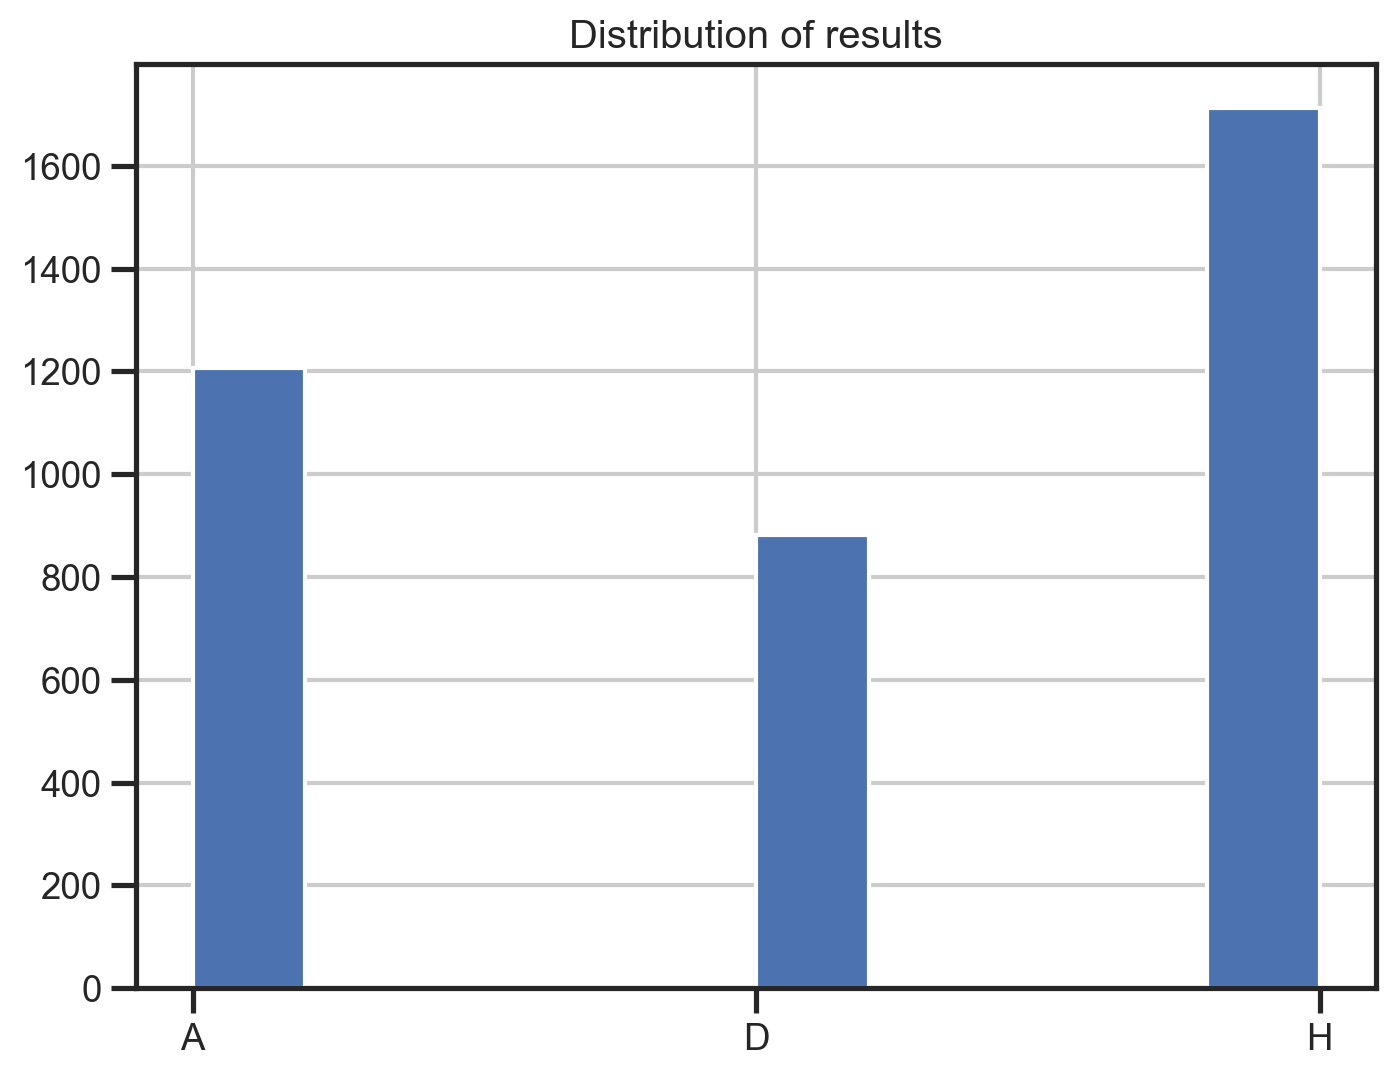

In [11]:
# Histogram - target variable
all_season_df['FTR'].hist()
plt.title('Distribution of results')
plt.show()

### Define the columns to keep

In [13]:
# Define the columns to keep
columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam','FTR', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
       'HC', 'HY', 'AY', 'HR', 'AR' ,'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'League Year']

# Drop all other columns except the specified ones
all_season_df = all_season_df[columns_to_keep]


In [14]:
all_season_df.head()

,Date,HomeTeam,AwayTeam,FTR,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,WHH,WHD,WHA,VCH,VCD,VCA,League Year
0,05/08/2022,Crystal Palace,Arsenal,A,0.0,1.0,10.0,10.0,2.0,2.0,3.0,1.0,2.0,0.0,0.0,4.20,3.6,1.85,4.33,3.50,1.87,4.40,3.5,1.83,4.60,3.5,1.87,2022
1,06/08/2022,Fulham,Liverpool,D,1.0,0.0,9.0,11.0,3.0,4.0,4.0,2.0,0.0,0.0,0.0,11.00,6.0,1.25,10.00,5.75,1.28,12.00,5.5,1.27,13.00,6.0,1.25,2022
2,06/08/2022,Bournemouth,Aston Villa,H,1.0,0.0,7.0,15.0,3.0,2.0,5.0,3.0,3.0,0.0,0.0,3.75,3.5,2.00,3.75,3.40,2.00,3.75,3.3,2.05,3.75,3.3,2.00,2022
3,06/08/2022,Leeds,Wolves,H,1.0,1.0,12.0,15.0,4.0,6.0,6.0,2.0,0.0,0.0,0.0,2.25,3.4,3.20,2.30,3.30,2.95,2.25,3.3,3.20,2.30,3.2,3.10,2022
4,06/08/2022,Newcastle,Nott'm Forest,H,0.0,0.0,23.0,5.0,10.0,0.0,11.0,0.0,3.0,0.0,0.0,1.66,3.8,5.25,1.65,3.80,5.50,1.67,3.7,5.25,1.62,3.7,5.50,2022


In [15]:
all_season_df.isnull().sum()

Date           1
HomeTeam       1
AwayTeam       1
FTR            1
HTHG           1
HTAG           1
HS             1
AS             1
HST            1
AST            1
HC             1
HY             1
AY             1
HR             1
AR             1
B365H          1
B365D          1
B365A          1
BWH            2
BWD            2
BWA            2
WHH            1
WHD            1
WHA            1
VCH            1
VCD            1
VCA            1
League Year    0
dtype: int64

In [16]:
#Drop row that are empty
all_season_df = all_season_df.dropna()

In [17]:
all_season_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3799 entries, 0 to 3800
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3799 non-null   object 
 1   HomeTeam     3799 non-null   object 
 2   AwayTeam     3799 non-null   object 
 3   FTR          3799 non-null   object 
 4   HTHG         3799 non-null   float64
 5   HTAG         3799 non-null   float64
 6   HS           3799 non-null   float64
 7   AS           3799 non-null   float64
 8   HST          3799 non-null   float64
 9   AST          3799 non-null   float64
 10  HC           3799 non-null   float64
 11  HY           3799 non-null   float64
 12  AY           3799 non-null   float64
 13  HR           3799 non-null   float64
 14  AR           3799 non-null   float64
 15  B365H        3799 non-null   float64
 16  B365D        3799 non-null   float64
 17  B365A        3799 non-null   float64
 18  BWH          3799 non-null   float64
 19  BWD   

### Average 4 betting website by Home win, Draw and Away win  

- B365  Bet365
- BW    Bet&Win
- WH    William Hill
- VC    VC Bet

In [18]:
# Calculate the averages for columns ending with 'H', 'D', and 'A'
all_season_df.loc[:, 'ExpectedBetHomeWin'] = all_season_df[['B365H', 'BWH', 'WHH', 'VCH']].mean(axis=1)
all_season_df.loc[:, 'ExpectedBetDraw'] = all_season_df[['B365D', 'BWD', 'WHD', 'VCD']].mean(axis=1)
all_season_df.loc[:, 'ExpectedBetAwayWin'] = all_season_df[['B365A', 'BWA', 'WHA', 'VCA']].mean(axis=1)

# Drop the original columns
all_season_df.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA'], axis=1, inplace=True)


In [19]:
all_season_df.head()

,Date,HomeTeam,AwayTeam,FTR,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,League Year,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin
0,05/08/2022,Crystal Palace,Arsenal,A,0.0,1.0,10.0,10.0,2.0,2.0,3.0,1.0,2.0,0.0,0.0,2022,4.3825,3.5250,1.8550
1,06/08/2022,Fulham,Liverpool,D,1.0,0.0,9.0,11.0,3.0,4.0,4.0,2.0,0.0,0.0,0.0,2022,11.5000,5.8125,1.2625
2,06/08/2022,Bournemouth,Aston Villa,H,1.0,0.0,7.0,15.0,3.0,2.0,5.0,3.0,3.0,0.0,0.0,2022,3.7500,3.3750,2.0125
3,06/08/2022,Leeds,Wolves,H,1.0,1.0,12.0,15.0,4.0,6.0,6.0,2.0,0.0,0.0,0.0,2022,2.2750,3.3000,3.1125
4,06/08/2022,Newcastle,Nott'm Forest,H,0.0,0.0,23.0,5.0,10.0,0.0,11.0,0.0,3.0,0.0,0.0,2022,1.6500,3.7500,5.3750


In [20]:
all_season_df.shape

(3799, 19)

### ENCODING THE TARGET

Lets transform home win(H) to 2, a home defeat(A) to 0 and a draw (D) to 1.

In [21]:
def categorize_victory(row):
    if row['FTR'] == 'A':
        return 0
    elif row['FTR'] == 'D':
        return 1
    else:
        return 2

In [22]:
all_season_df["FinalResult"] = all_season_df.apply(lambda row: categorize_victory(row),axis=1)
all_season_df.head()

,Date,HomeTeam,AwayTeam,FTR,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,League Year,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,FinalResult
0,05/08/2022,Crystal Palace,Arsenal,A,0.0,1.0,10.0,10.0,2.0,2.0,3.0,1.0,2.0,0.0,0.0,2022,4.3825,3.5250,1.8550,0
1,06/08/2022,Fulham,Liverpool,D,1.0,0.0,9.0,11.0,3.0,4.0,4.0,2.0,0.0,0.0,0.0,2022,11.5000,5.8125,1.2625,1
2,06/08/2022,Bournemouth,Aston Villa,H,1.0,0.0,7.0,15.0,3.0,2.0,5.0,3.0,3.0,0.0,0.0,2022,3.7500,3.3750,2.0125,2
3,06/08/2022,Leeds,Wolves,H,1.0,1.0,12.0,15.0,4.0,6.0,6.0,2.0,0.0,0.0,0.0,2022,2.2750,3.3000,3.1125,2
4,06/08/2022,Newcastle,Nott'm Forest,H,0.0,0.0,23.0,5.0,10.0,0.0,11.0,0.0,3.0,0.0,0.0,2022,1.6500,3.7500,5.3750,2


In [23]:
#Drop both HTR AND FTR as we have encoded the target
all_season_df.drop(['FTR'],axis = 1, inplace = True)
all_season_df.tail() 

,Date,HomeTeam,AwayTeam,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,League Year,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,FinalResult
3796,11/05/2014,Norwich,Arsenal,0.0,0.0,11.0,14.0,5.0,8.0,4.0,1.0,0.0,0.0,0.0,2013,4.3075,3.6250,1.8600,0
3797,11/05/2014,Southampton,Man United,1.0,0.0,15.0,8.0,6.0,2.0,6.0,3.0,2.0,0.0,0.0,2013,2.6000,3.3500,2.7700,1
3798,11/05/2014,Sunderland,Swansea,0.0,2.0,20.0,8.0,4.0,4.0,6.0,2.0,3.0,0.0,0.0,2013,2.2950,3.3500,3.2375,0
3799,11/05/2014,Tottenham,Aston Villa,3.0,0.0,12.0,4.0,6.0,1.0,5.0,1.0,0.0,0.0,0.0,2013,1.4875,4.3250,7.1875,2
3800,11/05/2014,West Brom,Stoke,0.0,1.0,17.0,15.0,4.0,4.0,11.0,0.0,0.0,0.0,0.0,2013,2.0625,3.4625,3.7125,0


### ENGINEER A COLUMN NAME GOAL DIFFERENCE

In [24]:
# Calculate the goal difference and ensure no negative values
all_season_df["Goal_Difference"] = (all_season_df["HTHG"] - all_season_df["HTAG"]).apply(lambda x: max(x, 0))


In [25]:
all_season_df.head()

,Date,HomeTeam,AwayTeam,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,League Year,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,FinalResult,Goal_Difference
0,05/08/2022,Crystal Palace,Arsenal,0.0,1.0,10.0,10.0,2.0,2.0,3.0,1.0,2.0,0.0,0.0,2022,4.3825,3.5250,1.8550,0,0.0
1,06/08/2022,Fulham,Liverpool,1.0,0.0,9.0,11.0,3.0,4.0,4.0,2.0,0.0,0.0,0.0,2022,11.5000,5.8125,1.2625,1,1.0
2,06/08/2022,Bournemouth,Aston Villa,1.0,0.0,7.0,15.0,3.0,2.0,5.0,3.0,3.0,0.0,0.0,2022,3.7500,3.3750,2.0125,2,1.0
3,06/08/2022,Leeds,Wolves,1.0,1.0,12.0,15.0,4.0,6.0,6.0,2.0,0.0,0.0,0.0,2022,2.2750,3.3000,3.1125,2,0.0
4,06/08/2022,Newcastle,Nott'm Forest,0.0,0.0,23.0,5.0,10.0,0.0,11.0,0.0,3.0,0.0,0.0,2022,1.6500,3.7500,5.3750,2,0.0


### Import the ranking table and merge

In [26]:
df_ranking = pd.read_csv('all_ranking_df.csv')

In [27]:
df_ranking.head()

,League Year,Team Name,Attack,Midfield,Defence,Overall
0,2022,Manchester City,85,87,84,85
1,2022,Liverpool,84,82,84,84
2,2022,Chelsea,83,79,83,83
3,2022,Spurs,84,83,80,82
4,2022,Manchester Utd,82,83,81,82


In [28]:
df_ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   League Year  200 non-null    int64 
 1   Team Name    200 non-null    object
 2   Attack       200 non-null    int64 
 3   Midfield     200 non-null    int64 
 4   Defence      200 non-null    int64 
 5   Overall      200 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 9.5+ KB


In [29]:
# Convert 'League Year' column to the same data type as 'HomeTeam' column
all_season_df['League Year'] = all_season_df['League Year'].astype(int)

# Perform the merge based on League Year and HomeTeam/Team Name
allseason_and_ranking_df = pd.merge(all_season_df, df_ranking, left_on=['League Year', 'HomeTeam'], right_on=['League Year', 'Team Name'], how='left')

# Renaming the 'Attack' and 'Midfield' columns
allseason_and_ranking_df = allseason_and_ranking_df.rename(columns={'Attack': 'Home_Attack', 'Midfield': 'Home_Midfield', 'Defence': 'Home_Defence', 'Overall': 'Home_Overall'})


# Drop the duplicate 'Team Name' column
allseason_and_ranking_df.drop('Team Name', axis=1, inplace=True)

In [30]:
allseason_and_ranking_df.head()

,Date,HomeTeam,AwayTeam,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,League Year,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,FinalResult,Goal_Difference,Home_Attack,Home_Midfield,Home_Defence,Home_Overall
0,05/08/2022,Crystal Palace,Arsenal,0.0,1.0,10.0,10.0,2.0,2.0,3.0,1.0,2.0,0.0,0.0,2022,4.3825,3.5250,1.8550,0,0.0,77.0,76.0,76.0,76.0
1,06/08/2022,Fulham,Liverpool,1.0,0.0,9.0,11.0,3.0,4.0,4.0,2.0,0.0,0.0,0.0,2022,11.5000,5.8125,1.2625,1,1.0,77.0,76.0,74.0,76.0
2,06/08/2022,Bournemouth,Aston Villa,1.0,0.0,7.0,15.0,3.0,2.0,5.0,3.0,3.0,0.0,0.0,2022,3.7500,3.3750,2.0125,2,1.0,NaN,NaN,NaN,NaN
3,06/08/2022,Leeds,Wolves,1.0,1.0,12.0,15.0,4.0,6.0,6.0,2.0,0.0,0.0,0.0,2022,2.2750,3.3000,3.1125,2,0.0,NaN,NaN,NaN,NaN
4,06/08/2022,Newcastle,Nott'm Forest,0.0,0.0,23.0,5.0,10.0,0.0,11.0,0.0,3.0,0.0,0.0,2022,1.6500,3.7500,5.3750,2,0.0,NaN,NaN,NaN,NaN


### CONCACTINATION AWAY RANKING TABLE TO COMPARE WITH HOME

In [31]:
# Perform the merge based on League Year and AwayTeam/Team Name
allseason_and_ranking_df = pd.merge(allseason_and_ranking_df, df_ranking, left_on=['League Year', 'AwayTeam'], right_on=['League Year', 'Team Name'], how='left')

# Renaming the 'Attack', 'Midfield', 'Defence', and 'Overall' columns for AwayTeam
allseason_and_ranking_df = allseason_and_ranking_df.rename(columns={'Attack': 'Away_Attack', 'Midfield': 'Away_Midfield', 'Defence': 'Away_Defence', 'Overall': 'Away_Overall'})

# Drop the duplicate 'Team Name' column
allseason_and_ranking_df.drop('Team Name', axis=1, inplace=True)


In [32]:
allseason_and_ranking_df.head()

,Date,HomeTeam,AwayTeam,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,League Year,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,FinalResult,Goal_Difference,Home_Attack,Home_Midfield,Home_Defence,Home_Overall,Away_Attack,Away_Midfield,Away_Defence,Away_Overall
0,05/08/2022,Crystal Palace,Arsenal,0.0,1.0,10.0,10.0,2.0,2.0,3.0,1.0,2.0,0.0,0.0,2022,4.3825,3.5250,1.8550,0,0.0,77.0,76.0,76.0,76.0,81.0,83.0,80.0,81.0
1,06/08/2022,Fulham,Liverpool,1.0,0.0,9.0,11.0,3.0,4.0,4.0,2.0,0.0,0.0,0.0,2022,11.5000,5.8125,1.2625,1,1.0,77.0,76.0,74.0,76.0,84.0,82.0,84.0,84.0
2,06/08/2022,Bournemouth,Aston Villa,1.0,0.0,7.0,15.0,3.0,2.0,5.0,3.0,3.0,0.0,0.0,2022,3.7500,3.3750,2.0125,2,1.0,NaN,NaN,NaN,NaN,78.0,79.0,79.0,79.0
3,06/08/2022,Leeds,Wolves,1.0,1.0,12.0,15.0,4.0,6.0,6.0,2.0,0.0,0.0,0.0,2022,2.2750,3.3000,3.1125,2,0.0,NaN,NaN,NaN,NaN,78.0,80.0,74.0,78.0
4,06/08/2022,Newcastle,Nott'm Forest,0.0,0.0,23.0,5.0,10.0,0.0,11.0,0.0,3.0,0.0,0.0,2022,1.6500,3.7500,5.3750,2,0.0,NaN,NaN,NaN,NaN,75.0,76.0,77.0,77.0


I observed that there was some NAN after merging which is not suppose to be, digging into the raking table below:

In [33]:
df_ranking['Team Name'].unique()

array(['Manchester City', 'Liverpool', 'Chelsea', 'Spurs',
       'Manchester Utd', 'Arsenal', 'Leicester City', 'West Ham',
       'Newcastle Utd', 'Aston Villa', 'Wolves', 'Everton',
       "Nott'm Forest", 'Crystal Palace', 'Leeds United', 'Fulham',
       'Southampton', 'Brighton', 'Brentford', 'AFC Bournemouth',
       'Manchester United', 'Tottenham Hotspur', 'West Ham United',
       'Wolverhampton Wanderers', 'Newcastle United', 'Burnley',
       'Brighton & Hove Albion', 'Watford', 'Norwich City',
       'West Bromwich Albion', 'Sheffield United', 'Bournemouth',
       'Huddersfield Town', 'Cardiff City', 'Stoke City', 'Swansea City',
       'Sunderland', 'Hull City', 'Middlesbrough', 'Queens Park Rangers'],
      dtype=object)

It is observed above that the naming convention is not right, e.g there is Manchester Utd and Manchester United which mean same club, this is so because the entry for the club name across different seasons where inputed different ways. This will be solved below:

In [34]:
# Replace the team names in the 'Team Name' column
team_mapping = {
    'Manchester Utd': 'Manchester United',
    'Spurs': 'Tottenham Hotspur',
    'West Ham': 'West Ham United',
    'Wolves': 'Wolverhampton Wanderers',
    'Newcastle Utd': 'Newcastle United',
    'Bournemouth': 'AFC Bournemouth',
    'Brighton': 'Brighton & Hove Albion'
}

df_ranking['Team Name'] = df_ranking['Team Name'].replace(team_mapping)

In [35]:
df_ranking['Team Name'].unique()

array(['Manchester City', 'Liverpool', 'Chelsea', 'Tottenham Hotspur',
       'Manchester United', 'Arsenal', 'Leicester City',
       'West Ham United', 'Newcastle United', 'Aston Villa',
       'Wolverhampton Wanderers', 'Everton', "Nott'm Forest",
       'Crystal Palace', 'Leeds United', 'Fulham', 'Southampton',
       'Brighton & Hove Albion', 'Brentford', 'AFC Bournemouth',
       'Burnley', 'Watford', 'Norwich City', 'West Bromwich Albion',
       'Sheffield United', 'Huddersfield Town', 'Cardiff City',
       'Stoke City', 'Swansea City', 'Sunderland', 'Hull City',
       'Middlesbrough', 'Queens Park Rangers'], dtype=object)

In [36]:
df_ranking['Team Name'].nunique()

33

From the team name, I noticed also that there are some teams that their names are not same written/spelt as the one in all season table, for example  

'Tottenham Hotspur'  'Tottenham'    
'Manchester United'  'Man United'   
'West Ham United'  'West Ham'   
'Wolverhampton Wanderers'  'Wolves'   
'AFC Bournemouth'  'Bournemouth'  
'Brighton & Hove Albion' 'Brighton'   
'Nott'm Forest'  "Nott'm Forest"   
'Manchester City' 'Man City'   
'Newcastle United' 'Newcastle'   
'Queens Park Rangers'   'QPR'   
'Leicester City'   'Leicester'  
'Norwich City'    'Norwich'  
'West Bromwich Albion'   'West Brom'  
'Huddersfield Town'     'Huddersfield'  
'Cardiff City',         'Cardiff'  
'Stoke City',         'Stoke'  
'Swansea City',      'Swansea'  
'Hull City'         'Hull'  
'Leeds United'    ''Leeds'  


In [37]:
# Dictionary of team name replacements
team_replacements = {
    'Tottenham Hotspur': 'Tottenham',
    'Manchester United': 'Man United',
    'West Ham United': 'West Ham',
    'Wolverhampton Wanderers': 'Wolves',
    'AFC Bournemouth': 'Bournemouth',
    'Brighton & Hove Albion': 'Brighton',
    "Nott'm Forest": "Nott'm Forest",
    'Manchester City': 'Man City',
    'Newcastle United': 'Newcastle',
    'Queens Park Rangers': 'QPR',
    'Leicester City': 'Leicester',
    'Norwich City': 'Norwich',
    'West Bromwich Albion': 'West Brom',
    'Huddersfield Town': 'Huddersfield',
    'Cardiff City': 'Cardiff',
    'Stoke City': 'Stoke',
    'Swansea City': 'Swansea',
    'Hull City': 'Hull',
    'Leeds United': 'Leeds'
}

# Replace team names in the 'team name' column using the dictionary
df_ranking['Team Name'] = df_ranking['Team Name'].replace(team_replacements)


Now mergeing again to see if there will be any NAN

In [38]:
# Convert 'League Year' column to the same data type as 'HomeTeam' column
all_season_df['League Year'] = all_season_df['League Year'].astype(int)

# Perform the merge based on League Year and HomeTeam/Team Name
allseason_and_ranking_df = pd.merge(all_season_df, df_ranking, left_on=['League Year', 'HomeTeam'], right_on=['League Year', 'Team Name'], how='left')

# Renaming the 'Attack' and 'Midfield' columns
allseason_and_ranking_df = allseason_and_ranking_df.rename(columns={'Attack': 'Home_Attack', 'Midfield': 'Home_Midfield', 'Defence': 'Home_Defence', 'Overall': 'Home_Overall'})


# Drop the duplicate 'Team Name' column
allseason_and_ranking_df.drop('Team Name', axis=1, inplace=True)

In [39]:
allseason_and_ranking_df.head()

,Date,HomeTeam,AwayTeam,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,League Year,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,FinalResult,Goal_Difference,Home_Attack,Home_Midfield,Home_Defence,Home_Overall
0,05/08/2022,Crystal Palace,Arsenal,0.0,1.0,10.0,10.0,2.0,2.0,3.0,1.0,2.0,0.0,0.0,2022,4.3825,3.5250,1.8550,0,0.0,77,76,76,76
1,06/08/2022,Fulham,Liverpool,1.0,0.0,9.0,11.0,3.0,4.0,4.0,2.0,0.0,0.0,0.0,2022,11.5000,5.8125,1.2625,1,1.0,77,76,74,76
2,06/08/2022,Bournemouth,Aston Villa,1.0,0.0,7.0,15.0,3.0,2.0,5.0,3.0,3.0,0.0,0.0,2022,3.7500,3.3750,2.0125,2,1.0,72,73,73,74
3,06/08/2022,Leeds,Wolves,1.0,1.0,12.0,15.0,4.0,6.0,6.0,2.0,0.0,0.0,0.0,2022,2.2750,3.3000,3.1125,2,0.0,77,76,75,76
4,06/08/2022,Newcastle,Nott'm Forest,0.0,0.0,23.0,5.0,10.0,0.0,11.0,0.0,3.0,0.0,0.0,2022,1.6500,3.7500,5.3750,2,0.0,79,78,79,79


In [40]:
# Perform the merge based on League Year and AwayTeam/Team Name
allseason_and_ranking_df = pd.merge(allseason_and_ranking_df, df_ranking, left_on=['League Year', 'AwayTeam'], right_on=['League Year', 'Team Name'], how='left')

# Renaming the 'Attack', 'Midfield', 'Defence', and 'Overall' columns for AwayTeam
allseason_and_ranking_df = allseason_and_ranking_df.rename(columns={'Attack': 'Away_Attack', 'Midfield': 'Away_Midfield', 'Defence': 'Away_Defence', 'Overall': 'Away_Overall'})

# Drop the duplicate 'Team Name' column
allseason_and_ranking_df.drop('Team Name', axis=1, inplace=True)


In [41]:
allseason_and_ranking_df.isnull().sum()

Date                  0
HomeTeam              0
AwayTeam              0
HTHG                  0
HTAG                  0
HS                    0
AS                    0
HST                   0
AST                   0
HC                    0
HY                    0
AY                    0
HR                    0
AR                    0
League Year           0
ExpectedBetHomeWin    0
ExpectedBetDraw       0
ExpectedBetAwayWin    0
FinalResult           0
Goal_Difference       0
Home_Attack           0
Home_Midfield         0
Home_Defence          0
Home_Overall          0
Away_Attack           0
Away_Midfield         0
Away_Defence          0
Away_Overall          0
dtype: int64

In [42]:
allseason_and_ranking_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3799 entries, 0 to 3798
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3799 non-null   object 
 1   HomeTeam            3799 non-null   object 
 2   AwayTeam            3799 non-null   object 
 3   HTHG                3799 non-null   float64
 4   HTAG                3799 non-null   float64
 5   HS                  3799 non-null   float64
 6   AS                  3799 non-null   float64
 7   HST                 3799 non-null   float64
 8   AST                 3799 non-null   float64
 9   HC                  3799 non-null   float64
 10  HY                  3799 non-null   float64
 11  AY                  3799 non-null   float64
 12  HR                  3799 non-null   float64
 13  AR                  3799 non-null   float64
 14  League Year         3799 non-null   int64  
 15  ExpectedBetHomeWin  3799 non-null   float64
 16  Expect

In [43]:
allseason_and_ranking_df.shape

(3799, 28)

### Working with the Weather Data

In [44]:
weather_df = pd.read_csv('england_weather.csv')

In [45]:
weather_df.head()

,datetime,temp,precip,windspeed
0,2013-01-01,43.8,0.170,13.5
1,2013-01-02,44.3,0.020,11.3
2,2013-01-03,51.5,0.000,14.1
3,2013-01-04,50.0,0.012,12.4
4,2013-01-05,48.9,0.000,10.7


Precipitation is any liquid or frozen water that forms in the atmosphere and falls back to the earth, which mean if precip is greather than 1, it rained, if not there was no rain, I will be using the column to create another columns which will be named rain.

In [46]:
# Function to transform precip into numeric data type, rain = 1 and no rain = 0
def rainornot(row):
    if row.precip > 0:
        return 1
    else:
        return 0

# Apply the function to create the 'rain' column
weather_df["rain"] = weather_df.apply(rainornot, axis=1)
# Drop Precip column
weather_df = weather_df.drop('precip', axis = 1)

In [47]:
weather_df.head()

,datetime,temp,windspeed,rain
0,2013-01-01,43.8,13.5,1
1,2013-01-02,44.3,11.3,1
2,2013-01-03,51.5,14.1,0
3,2013-01-04,50.0,12.4,1
4,2013-01-05,48.9,10.7,0


### Merge weather data to all season and raking data

Both tables will be merge with date, but It is observed that the date column has a different format, I will have to format the date column to be same.

In [48]:

# Convert date column in allseason_and_ranking_df to the desired format
allseason_and_ranking_df['Date'] = pd.to_datetime(allseason_and_ranking_df['Date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

# Convert date column in weather_df to the desired format
weather_df['datetime'] = pd.to_datetime(weather_df['datetime']).dt.strftime('%Y-%m-%d')


In [49]:
weather_df.head(2)

,datetime,temp,windspeed,rain
0,2013-01-01,43.8,13.5,1
1,2013-01-02,44.3,11.3,1


In [50]:
allseason_and_ranking_df.head(2)

,Date,HomeTeam,AwayTeam,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,League Year,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,FinalResult,Goal_Difference,Home_Attack,Home_Midfield,Home_Defence,Home_Overall,Away_Attack,Away_Midfield,Away_Defence,Away_Overall
0,2022-08-05,Crystal Palace,Arsenal,0.0,1.0,10.0,10.0,2.0,2.0,3.0,1.0,2.0,0.0,0.0,2022,4.3825,3.5250,1.8550,0,0.0,77,76,76,76,81,83,80,81
1,2022-08-06,Fulham,Liverpool,1.0,0.0,9.0,11.0,3.0,4.0,4.0,2.0,0.0,0.0,0.0,2022,11.5000,5.8125,1.2625,1,1.0,77,76,74,76,84,82,84,84


In [51]:
final_df = pd.merge(weather_df, allseason_and_ranking_df, left_on='datetime', right_on='Date')
final_df = final_df.drop(['datetime', 'Date'], axis=1)


In [52]:
final_df.head()

,temp,windspeed,rain,HomeTeam,AwayTeam,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,League Year,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,FinalResult,Goal_Difference,Home_Attack,Home_Midfield,Home_Defence,Home_Overall,Away_Attack,Away_Midfield,Away_Defence,Away_Overall
0,63.1,19.2,0,Arsenal,Aston Villa,1.0,1.0,16.0,9.0,4.0,4.0,4.0,4.0,5.0,1.0,0.0,2013,1.4000,4.8375,7.9375,0,0.0,79,81,80,80,72,71,74,74
1,63.1,19.2,0,Liverpool,Stoke,1.0,0.0,26.0,10.0,11.0,4.0,12.0,1.0,1.0,0.0,0.0,2013,1.3900,4.7325,9.0625,2,1.0,76,79,78,80,76,73,73,74
2,63.1,19.2,0,Norwich,Everton,0.0,0.0,8.0,19.0,2.0,6.0,6.0,2.0,0.0,0.0,0.0,2013,3.1300,3.3375,2.3500,1,0.0,74,74,74,74,78,78,78,78
3,63.1,19.2,0,Sunderland,Fulham,0.0,0.0,20.0,5.0,3.0,1.0,6.0,0.0,3.0,0.0,0.0,2013,2.2625,3.3250,3.3125,0,0.0,74,73,73,74,71,74,72,75
4,63.1,19.2,0,Swansea,Man United,0.0,2.0,17.0,15.0,6.0,7.0,7.0,1.0,3.0,0.0,0.0,2013,4.0250,3.5000,1.9575,0,0.0,79,74,75,76,85,79,80,82


In [53]:
final_df.shape

(3799, 30)

In [54]:
# Save the DataFrame as a CSV file
final_df.to_csv('final_df.csv', index=False)

In [55]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3799 entries, 0 to 3798
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temp                3799 non-null   float64
 1   windspeed           3799 non-null   float64
 2   rain                3799 non-null   int64  
 3   HomeTeam            3799 non-null   object 
 4   AwayTeam            3799 non-null   object 
 5   HTHG                3799 non-null   float64
 6   HTAG                3799 non-null   float64
 7   HS                  3799 non-null   float64
 8   AS                  3799 non-null   float64
 9   HST                 3799 non-null   float64
 10  AST                 3799 non-null   float64
 11  HC                  3799 non-null   float64
 12  HY                  3799 non-null   float64
 13  AY                  3799 non-null   float64
 14  HR                  3799 non-null   float64
 15  AR                  3799 non-null   float64
 16  League

<Axes: >

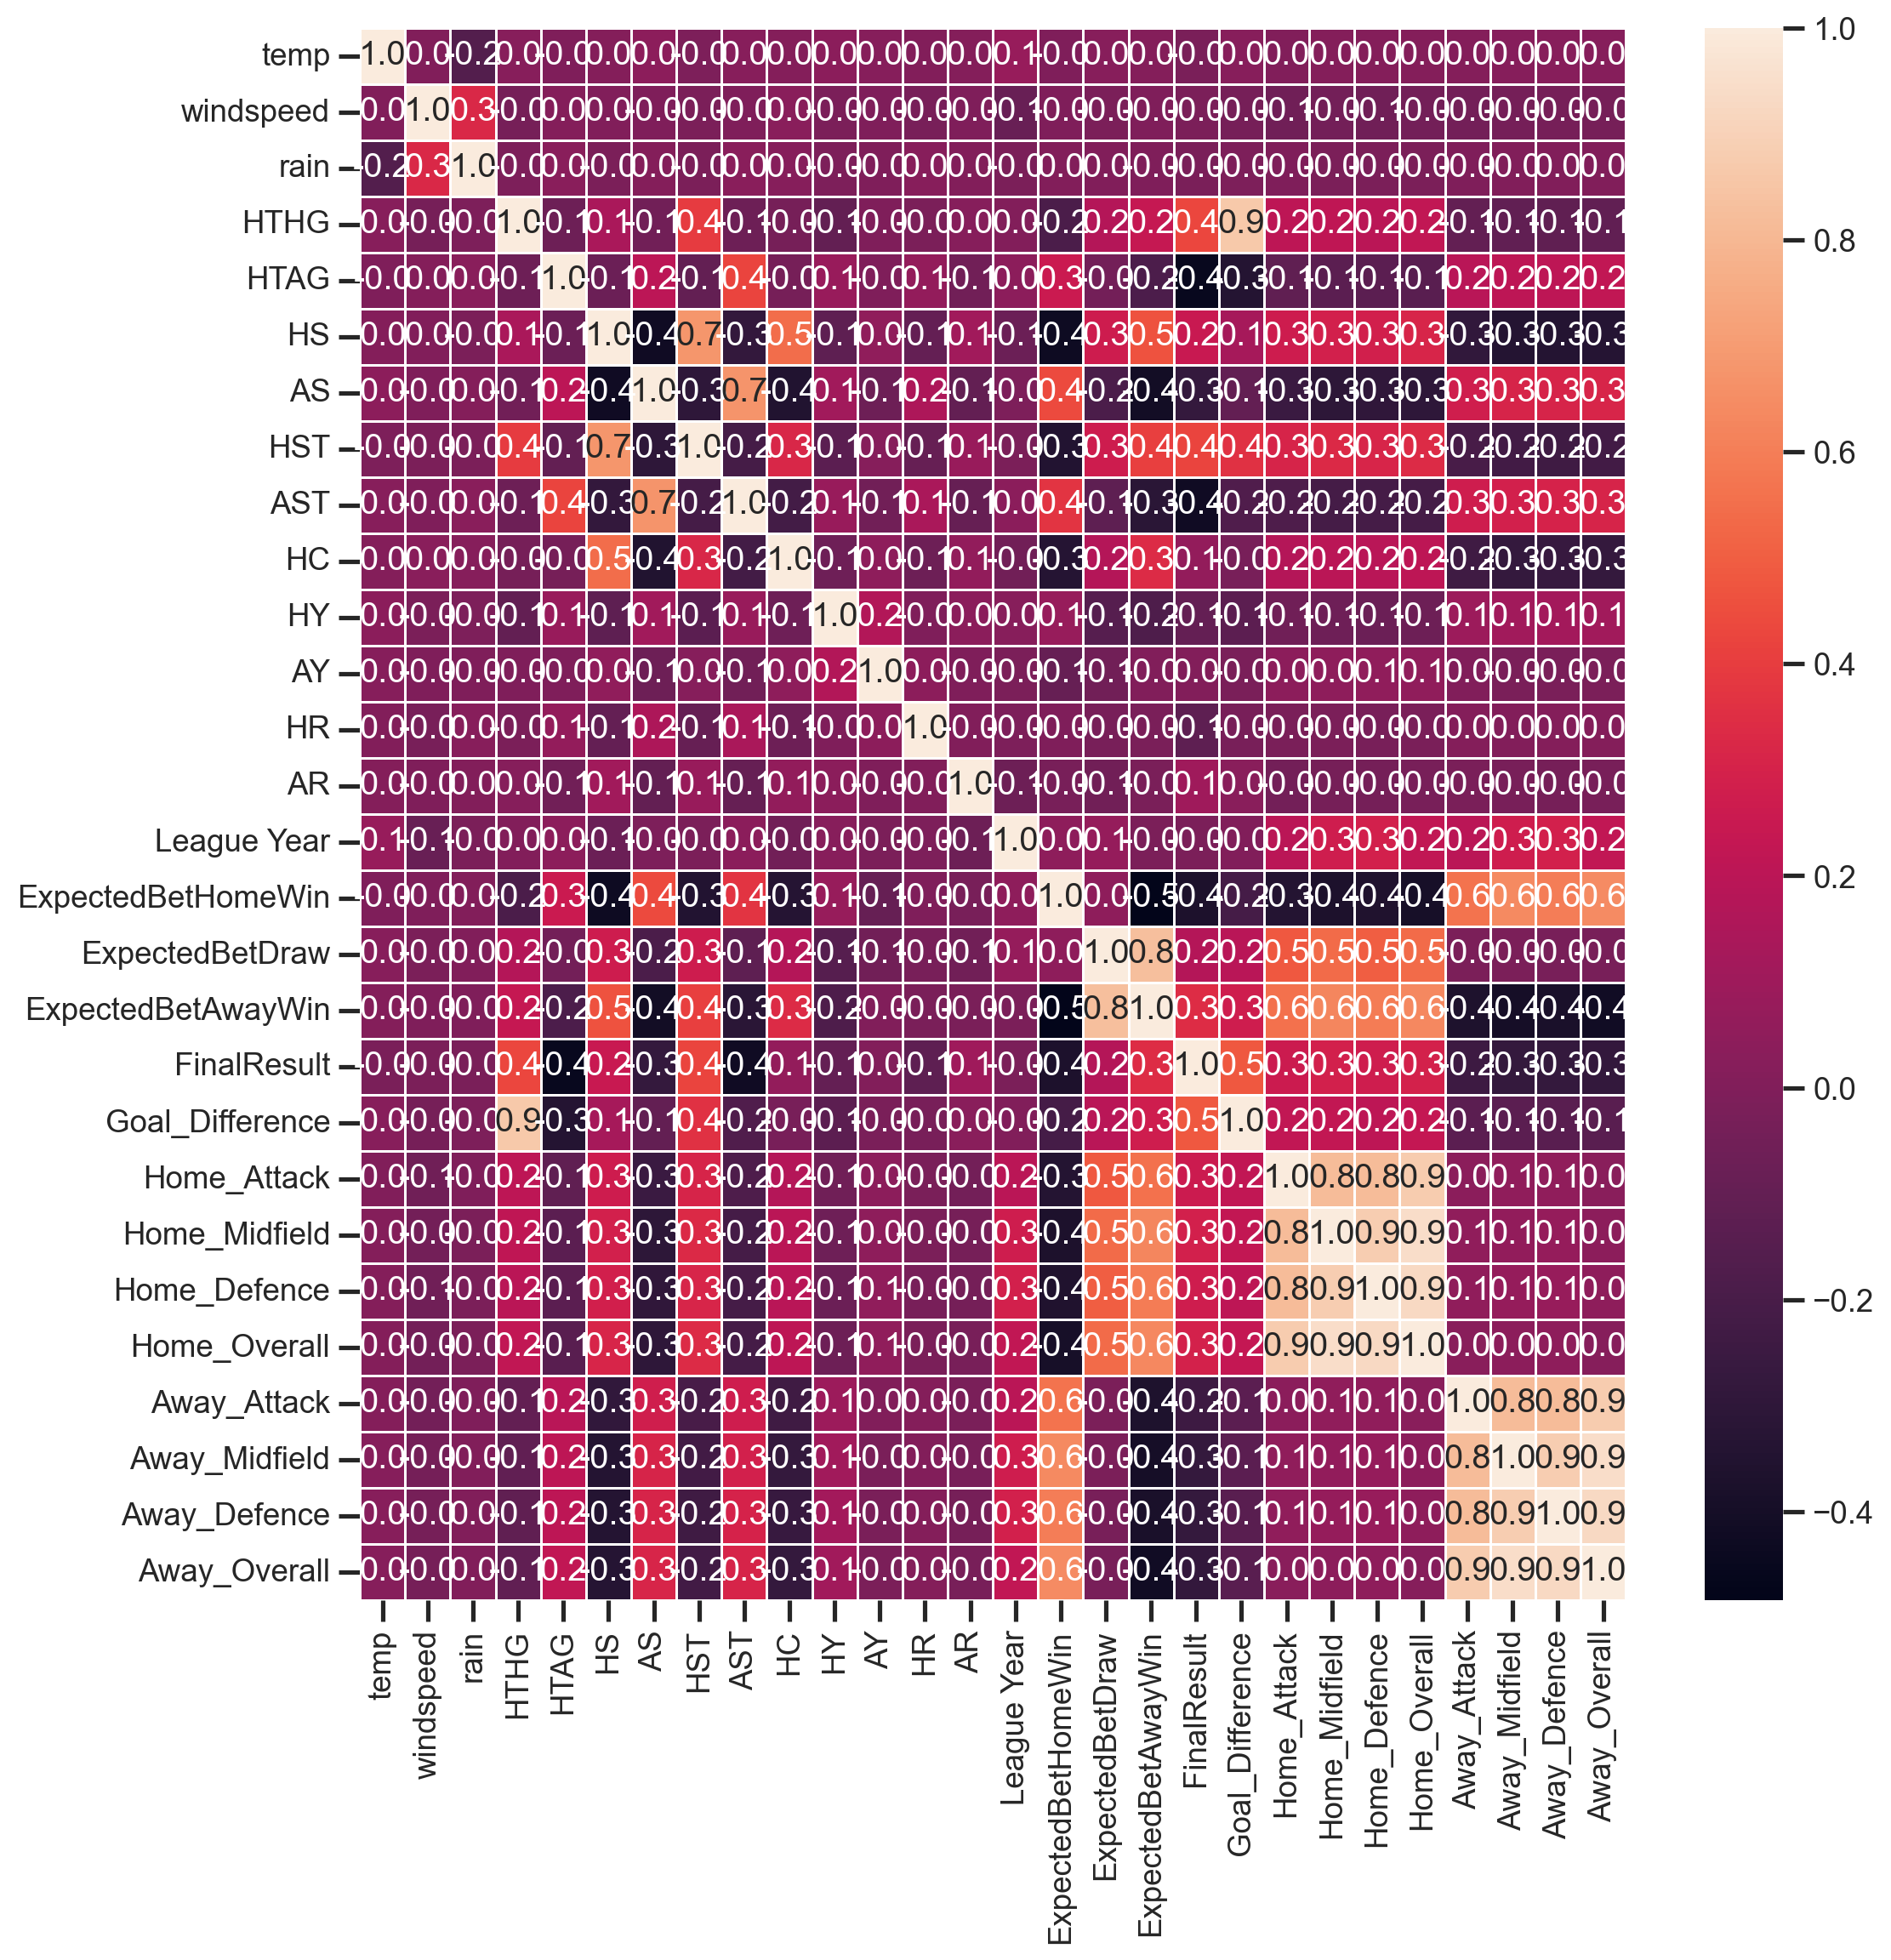

In [56]:
#correlation map
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(final_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [57]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, RFECV 
from category_encoders import TargetEncoder
import category_encoders as ce

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from functools import partial
rmse = partial(mean_squared_error, squared=False)

import warnings 
warnings.filterwarnings("ignore")

In [58]:
X = final_df.drop(columns=['FinalResult'])
y = final_df['FinalResult']

In [59]:
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [60]:
def preprocessor_pipe():
    numeric_features = X.select_dtypes(exclude='object').columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            ("scaler", MinMaxScaler())
        ]
    ).set_output(transform='pandas')

    categorical_features = ['HomeTeam','AwayTeam']
    categorical_transformer = Pipeline(
        steps=[
            ("te", ce.TargetEncoder(cols=categorical_features)),
            ("scaler", MinMaxScaler())
        ]
    ).set_output(transform='pandas')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    return preprocessor

In [61]:
preprocessor = preprocessor_pipe() 

In [62]:
preprocessor.fit(X_train, y_train) 

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['temp', 'windspeed', 'rain', 'HTHG', 'HTAG',
                                  'HS', 'AS', 'HST', 'AST', 'HC', 'HY', 'AY',
                                  'HR', 'AR', 'League Year',
                                  'ExpectedBetHomeWin', 'ExpectedBetDraw',
                                  'ExpectedBetAwayWin', 'Goal_Difference',
                                  'Home_Attack', 'Home_Midfield',
                                  'Home_Defence', 'Home_Overall', 'Away_Attack',
                                  'Away_Midfield', 'Away_Defence',
                                  'Away_Overall']),
                                ('cat',
                                 Pipeline(steps=[('te',
                                                  TargetEncoder(cols=['HomeTeam',
                                                                      'AwayTeam'])),
                                                 ('scaler', MinMaxScaler())]),
                                 ['HomeTeam', 'AwayTeam'])],
                  verbose_feature_names_out=False)

In [63]:
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed= preprocessor.transform(X_test)

In [64]:
X_train_preprocessed.head()

,temp,windspeed,rain,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,League Year,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,Goal_Difference,Home_Attack,Home_Midfield,Home_Defence,Home_Overall,Away_Attack,Away_Midfield,Away_Defence,Away_Overall,HomeTeam,AwayTeam
674,0.322314,0.388158,0.0,0.4,0.2,0.214286,0.451613,0.235294,0.333333,0.210526,0.285714,0.142857,0.0,0.0,0.111111,0.025471,0.098052,0.113792,0.2,0.45,0.388889,0.500000,0.533333,0.10,0.111111,0.000000,0.133333,0.671924,0.515344
2650,0.667355,0.365132,1.0,0.2,0.2,0.285714,0.451613,0.117647,0.266667,0.315789,0.428571,0.000000,0.0,0.0,0.666667,0.062016,0.038961,0.048126,0.0,0.40,0.333333,0.444444,0.400000,0.30,0.333333,0.444444,0.400000,0.255278,0.615727
248,0.293388,0.677632,1.0,0.0,0.2,0.714286,0.193548,0.529412,0.200000,0.526316,0.000000,0.000000,0.0,0.0,0.000000,0.007506,0.291126,0.396886,0.0,0.80,0.500000,0.666667,0.800000,0.10,0.222222,0.222222,0.333333,0.807458,0.787761
3099,0.487603,0.421053,1.0,0.2,0.0,0.285714,0.387097,0.352941,0.133333,0.526316,0.142857,0.142857,0.0,0.0,0.888889,0.020180,0.118615,0.149178,0.2,0.65,0.722222,0.722222,0.866667,0.45,0.444444,0.500000,0.533333,0.807458,0.568560
1,0.673554,0.529605,0.0,0.2,0.0,0.595238,0.322581,0.647059,0.266667,0.631579,0.142857,0.142857,0.0,0.0,0.000000,0.016365,0.154329,0.195335,0.2,0.35,0.500000,0.555556,0.666667,0.35,0.166667,0.277778,0.266667,0.873275,0.654877


## MODELS FOR ALL THE FEATURES

In [65]:
 def model_selection(xtrain,xtest,ytrain,ytest):
    models = {
        'logistic_regression':{
            'model':LogisticRegression()
        },
        'random_forest':{
            'model':RandomForestClassifier(random_state=seed)
        },
        'gradient_boost':{
            'model':GradientBoostingClassifier(random_state=seed)
        },
        'Decision_Tree':{
            'model':DecisionTreeClassifier(random_state=seed)
        },
       'Support_vector':{
            'model':SVC(random_state=seed)
        },
        'mlp_classifier':{
            'model': MLPClassifier(random_state=seed)
        }
    }

    scores = []
    for model_name, config in models.items():
        start = time.time()
        config['model'].fit(xtrain, ytrain)
        y_pred = config['model'].predict(xtest) 
        train_score = config['model'].score(xtrain, ytrain)
        accuracy = accuracy_score(ytest, y_pred)
        precision = precision_score(ytest, y_pred, average='weighted')
        recall = recall_score(ytest, y_pred, average='weighted')
        #f1 = f1(ytest, y_pred, average='weighted')
        end = time.time()
        elasped_time = end - start
        scores.append({
            'model': model_name,
            'train_score':train_score,
            'Accuracy':accuracy,
            'Precision':precision,
            'recall':recall,
            #'f1':f1,
            'time_taken':elasped_time})

    return pd.DataFrame(scores,columns=['model','train_score','Accuracy','Precision','recall','time_taken'])

In [66]:
result_whole = model_selection(X_train_preprocessed, X_test_preprocessed, y_train, y_test)

In [67]:
result_whole.sort_values(by='Accuracy',ascending=False)

,model,train_score,Accuracy,Precision,recall,time_taken
0,logistic_regression,0.681643,0.680000,0.645227,0.680000,0.108057
1,random_forest,1.000000,0.677895,0.654058,0.677895,0.641848
4,Support_vector,0.724114,0.675789,0.651580,0.675789,1.599127
2,gradient_boost,0.781327,0.672632,0.651764,0.672632,2.258526
5,mlp_classifier,0.717094,0.661053,0.642785,0.661053,2.339906
3,Decision_Tree,1.000000,0.553684,0.558571,0.553684,0.037974


## MODELS USING RECURSIVE FUTURE SELECTION(REFCV)

In [68]:
model = Ridge()
ref_selector = RFECV(model, step=1, cv=10)

In [69]:
ref_selector.fit(X_train_preprocessed, y_train)

RFECV(cv=10, estimator=Ridge())

In [70]:
n_scores = len(ref_selector.cv_results_["mean_test_score"])
n_scores

29

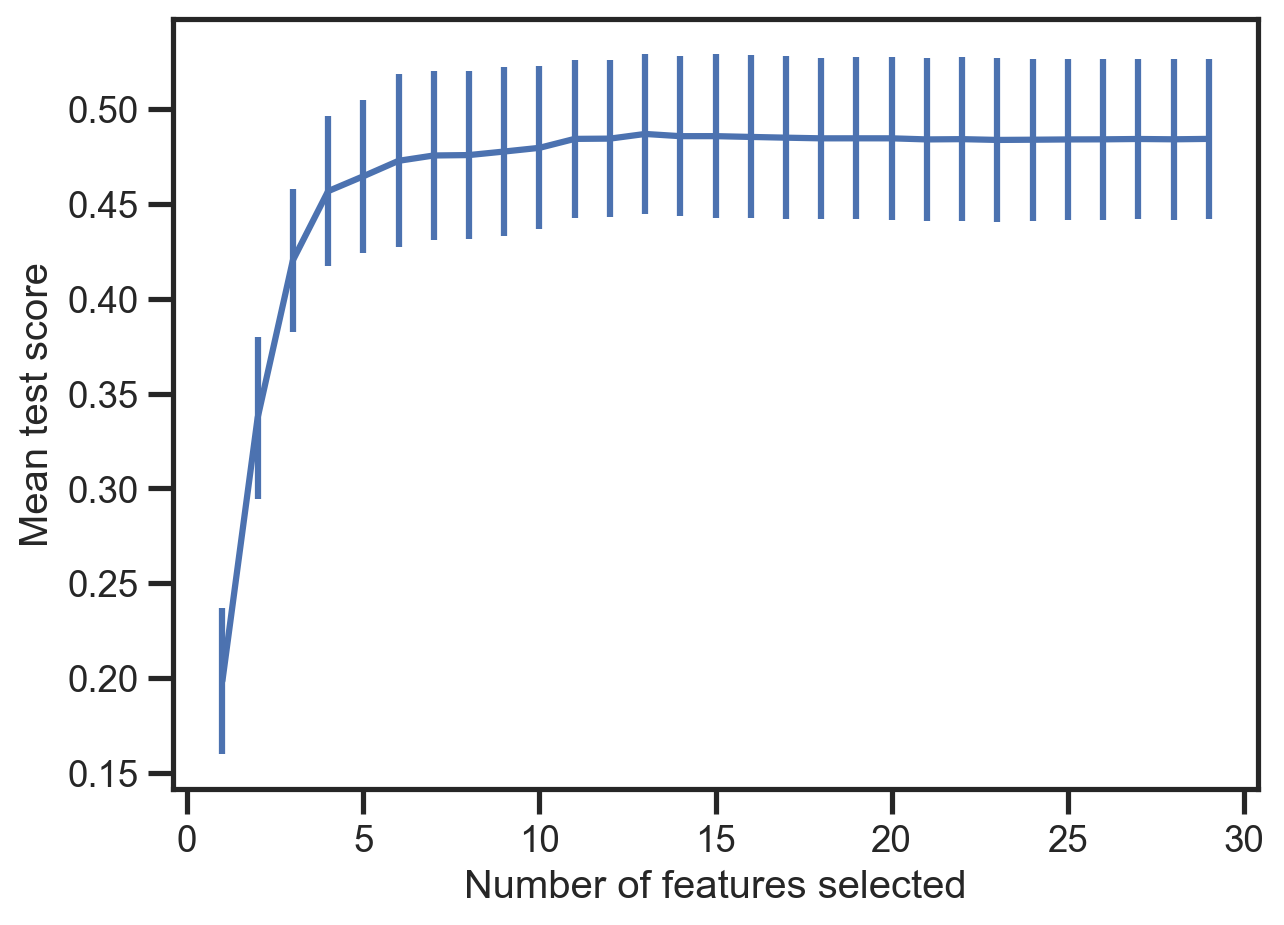

In [71]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_selector.cv_results_["mean_test_score"],
    yerr=ref_selector.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [72]:
pd.DataFrame(ref_selector.cv_results_["mean_test_score"],range(1, n_scores+1)).sort_values(by=0,ascending=False).head()

,0
13,0.486914
15,0.485756
14,0.485741
16,0.485338
17,0.484943


In [73]:
# Get the indices of the top performing features
top_features_idx = ref_selector.get_support(indices=True)

# Get the names of the top performing features
top_features_names = X_train_preprocessed.columns[top_features_idx]

# Print the top performing features
print("Top performing features:")
print(len(top_features_names))


Top performing features:
13


In [74]:
assert [i for i in top_features_names] == [i for i in ref_selector.get_feature_names_out()]

In [75]:
result_refcv_full = model_selection(X_train_preprocessed[top_features_names], X_test_preprocessed[top_features_names], y_train, y_test)

In [76]:
result_refcv_full .sort_values(by="Accuracy", ascending=False)

,model,train_score,Accuracy,Precision,recall,time_taken
4,Support_vector,0.699544,0.701053,0.676559,0.701053,1.149808
0,logistic_regression,0.682345,0.688421,0.644933,0.688421,0.050983
5,mlp_classifier,0.690067,0.684211,0.661172,0.684211,3.015435
1,random_forest,1.000000,0.673684,0.651279,0.673684,0.693502
2,gradient_boost,0.759214,0.669474,0.640378,0.669474,1.463772
3,Decision_Tree,1.000000,0.549474,0.558638,0.549474,0.023616


## MODELS USING SELECT K BEST

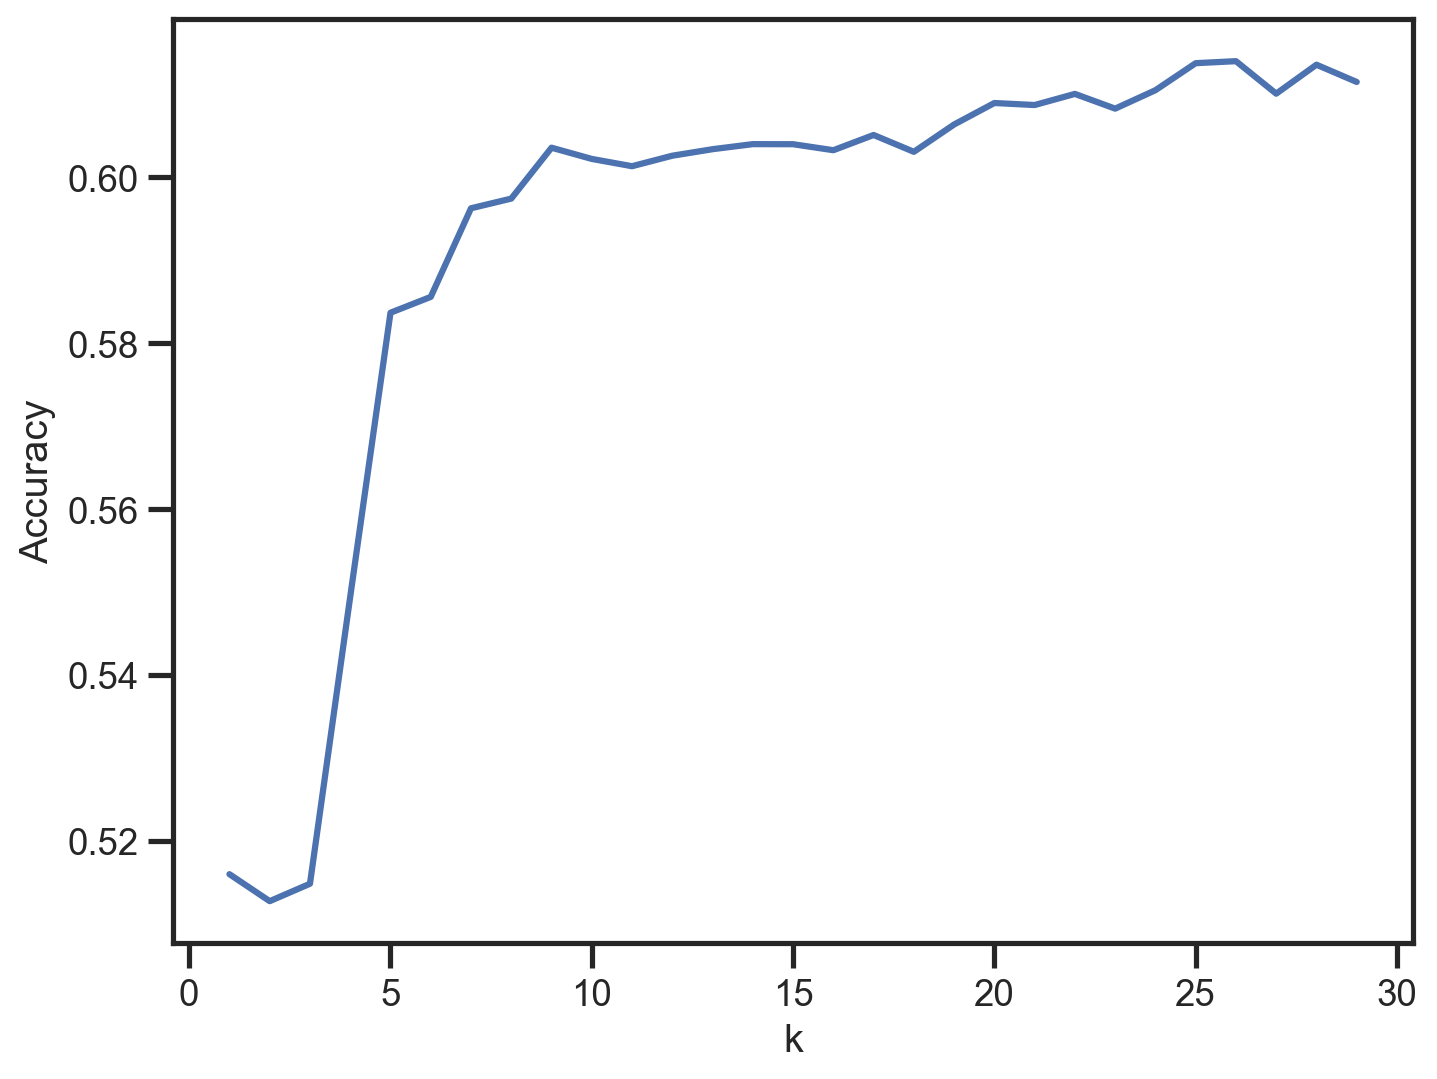

In [77]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

k_values = range(1, X.shape[1] + 1)
cv_scores = []
for k in k_values:
    selector = SelectKBest(chi2, k=k)
    X_selected = selector.fit_transform(X_train_preprocessed, y_train)
    
    # Step 5: Train and evaluate a logistic regression model using cross-validation
    clf = LogisticRegression(multi_class='ovr', max_iter=1000)
    scores = cross_val_score(clf, X_selected, y_train, cv=10, scoring='balanced_accuracy')
    cv_scores.append(np.mean(scores))

# Plot the accuracy as a function of k
import matplotlib.pyplot as plt
plt.plot(k_values, cv_scores)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

From the above plot, it is showing that at 25 we have our best model result

In [78]:
from sklearn.pipeline import make_pipeline

selector = make_pipeline(
    SelectKBest(chi2, k=25).fit(X_train_preprocessed, y_train)
).set_output(transform='pandas')

In [79]:
selector.get_feature_names_out()

array(['HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'HY', 'AY', 'HR',
       'AR', 'ExpectedBetHomeWin', 'ExpectedBetDraw',
       'ExpectedBetAwayWin', 'Goal_Difference', 'Home_Attack',
       'Home_Midfield', 'Home_Defence', 'Home_Overall', 'Away_Attack',
       'Away_Midfield', 'Away_Defence', 'Away_Overall', 'HomeTeam',
       'AwayTeam'], dtype=object)

In [80]:
cols_of_interest = ['HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'HY', 'AY', 'HR',
       'AR', 'ExpectedBetHomeWin', 'ExpectedBetDraw',
       'ExpectedBetAwayWin', 'Goal_Difference', 'Home_Attack',
       'Home_Midfield', 'Home_Defence', 'Home_Overall', 'Away_Attack',
       'Away_Midfield', 'Away_Defence', 'Away_Overall', 'HomeTeam',
       'AwayTeam']

In [81]:
X = final_df[cols_of_interest]
y = final_df['FinalResult']

In [82]:
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [83]:
X_train

,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,Goal_Difference,Home_Attack,Home_Midfield,Home_Defence,Home_Overall,Away_Attack,Away_Midfield,Away_Defence,Away_Overall,HomeTeam,AwayTeam
674,2.0,1.0,10.0,14.0,4.0,5.0,4.0,2.0,1.0,0.0,0.0,1.5750,4.0825,5.7500,1.0,78,77,77,78,71,72,68,72,Tottenham,Leicester
2650,1.0,1.0,13.0,14.0,2.0,4.0,6.0,3.0,0.0,0.0,0.0,2.3175,3.4000,3.0825,0.0,77,76,76,76,75,76,76,76,Burnley,Brighton
248,0.0,1.0,31.0,6.0,9.0,3.0,10.0,0.0,0.0,0.0,0.0,1.2100,6.3125,17.2500,0.0,85,79,80,82,71,74,72,75,Man United,Fulham
3099,1.0,0.0,13.0,12.0,6.0,2.0,10.0,1.0,1.0,0.0,0.0,1.4675,4.3200,7.1875,1.0,82,83,81,83,78,78,77,78,Man United,Everton
1,1.0,0.0,26.0,10.0,11.0,4.0,12.0,1.0,1.0,0.0,0.0,1.3900,4.7325,9.0625,1.0,76,79,78,80,76,73,73,74,Liverpool,Stoke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276,0.0,2.0,11.0,10.0,1.0,4.0,4.0,1.0,4.0,0.0,0.0,1.6450,3.6000,5.7625,0.0,75,73,77,76,77,75,76,76,Brighton,Burnley
3125,0.0,3.0,10.0,23.0,5.0,14.0,7.0,2.0,3.0,0.0,0.0,7.6250,4.6875,1.4075,0.0,75,73,77,76,84,87,86,85,Brighton,Man City
1318,1.0,1.0,9.0,17.0,2.0,5.0,2.0,1.0,4.0,1.0,0.0,2.8375,3.2250,2.5950,0.0,78,76,77,78,85,81,81,81,Southampton,Tottenham
723,1.0,1.0,12.0,11.0,6.0,2.0,1.0,2.0,2.0,0.0,1.0,4.0000,3.2625,2.0500,0.0,76,73,72,74,77,75,76,76,Sunderland,Southampton


In [84]:
preprocessor = preprocessor_pipe() 

In [85]:
preprocessor.fit(X_train, y_train) 

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
                                  'HC', 'HY', 'AY', 'HR', 'AR',
                                  'ExpectedBetHomeWin', 'ExpectedBetDraw',
                                  'ExpectedBetAwayWin', 'Goal_Difference',
                                  'Home_Attack', 'Home_Midfield',
                                  'Home_Defence', 'Home_Overall', 'Away_Attack',
                                  'Away_Midfield', 'Away_Defence',
                                  'Away_Overall']),
                                ('cat',
                                 Pipeline(steps=[('te',
                                                  TargetEncoder(cols=['HomeTeam',
                                                                      'AwayTeam'])),
                                                 ('scaler', MinMaxScaler())]),
                                 ['HomeTeam', 'AwayTeam'])],
                  verbose_feature_names_out=False)

In [86]:
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed= preprocessor.transform(X_test)

In [87]:
X_train_preprocessed.head()

,HTHG,HTAG,HS,AS,HST,AST,HC,HY,AY,HR,AR,ExpectedBetHomeWin,ExpectedBetDraw,ExpectedBetAwayWin,Goal_Difference,Home_Attack,Home_Midfield,Home_Defence,Home_Overall,Away_Attack,Away_Midfield,Away_Defence,Away_Overall,HomeTeam,AwayTeam
674,0.4,0.2,0.214286,0.451613,0.235294,0.333333,0.210526,0.285714,0.142857,0.0,0.0,0.025471,0.098052,0.113792,0.2,0.45,0.388889,0.500000,0.533333,0.10,0.111111,0.000000,0.133333,0.671924,0.515344
2650,0.2,0.2,0.285714,0.451613,0.117647,0.266667,0.315789,0.428571,0.000000,0.0,0.0,0.062016,0.038961,0.048126,0.0,0.40,0.333333,0.444444,0.400000,0.30,0.333333,0.444444,0.400000,0.255278,0.615727
248,0.0,0.2,0.714286,0.193548,0.529412,0.200000,0.526316,0.000000,0.000000,0.0,0.0,0.007506,0.291126,0.396886,0.0,0.80,0.500000,0.666667,0.800000,0.10,0.222222,0.222222,0.333333,0.807458,0.787761
3099,0.2,0.0,0.285714,0.387097,0.352941,0.133333,0.526316,0.142857,0.142857,0.0,0.0,0.020180,0.118615,0.149178,0.2,0.65,0.722222,0.722222,0.866667,0.45,0.444444,0.500000,0.533333,0.807458,0.568560
1,0.2,0.0,0.595238,0.322581,0.647059,0.266667,0.631579,0.142857,0.142857,0.0,0.0,0.016365,0.154329,0.195335,0.2,0.35,0.500000,0.555556,0.666667,0.35,0.166667,0.277778,0.266667,0.873275,0.654877


In [88]:
 def model_selection(xtrain,xtest,ytrain,ytest):
    models = {
        'logistic_regression':{
            'model':LogisticRegression()
        },
        'random_forest':{
            'model':RandomForestClassifier(random_state=seed)
        },
        'gradient_boost':{
            'model':GradientBoostingClassifier(random_state=seed)
        },
        'Decision_Tree':{
            'model':DecisionTreeClassifier(random_state=seed)
        },
       'Support_vector':{
            'model':SVC(random_state=seed)
        },
        'mlp_classifier':{
            'model': MLPClassifier(random_state=seed)
        }
    }

    scores = []
    for model_name, config in models.items():
        start = time.time()
        config['model'].fit(xtrain, ytrain)
        y_pred = config['model'].predict(xtest) 
        train_score = config['model'].score(xtrain, ytrain)
        accuracy = accuracy_score(ytest, y_pred)
        precision = precision_score(ytest, y_pred, average='weighted')
        recall = recall_score(ytest, y_pred, average='weighted')
        #f1 = f1(ytest, y_pred, average='weighted')
        end = time.time()
        elasped_time = end - start
        scores.append({
            'model': model_name,
            'train_score':train_score,
            'Accuracy':accuracy,
            'Precision':precision,
            'recall':recall,
            #'f1':f1,
            'time_taken':elasped_time})

    return pd.DataFrame(scores,columns=['model','train_score','Accuracy','Precision','recall','time_taken'])

In [89]:
result_selkbest = model_selection(X_train_preprocessed, X_test_preprocessed, y_train, y_test)

In [90]:
result_selkbest.sort_values(by='Accuracy',ascending=False)

,model,train_score,Accuracy,Precision,recall,time_taken
4,Support_vector,0.708670,0.703158,0.684820,0.703158,1.357400
0,logistic_regression,0.680239,0.682105,0.647975,0.682105,0.070586
5,mlp_classifier,0.702352,0.681053,0.661228,0.681053,3.477879
1,random_forest,1.000000,0.678947,0.655483,0.678947,1.058920
2,gradient_boost,0.776764,0.671579,0.655051,0.671579,3.564872
3,Decision_Tree,1.000000,0.560000,0.573057,0.560000,0.032368


### Building a Gridsearch model on the first 4 models using top 25 features generated by SelectKbest  
Support Vector  
Logistic Regression  
MLP Classifier  
Random Forest  


In [91]:
models = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])

def accuracy_cv(model):
    accuracy = cross_val_score(model, X, y, scoring="accuracy", cv=5).mean()
    return accuracy

def evaluation(y, predictions):
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, average='weighted')
    recall = recall_score(y, predictions, average='weighted')
    f1 = f1_score(y, predictions, average='weighted')
    return accuracy, precision, recall, f1


In [92]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a figure and axis
    plt.figure(figsize=(5, 3))
    ax = plt.gca()

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax, xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

    # Set labels, title, and ticks
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')


    # Rotate tick labels for better visibility
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Show the plot
    plt.show()


### SOPPORT VECTOR MODEL

In [93]:
svc = SVC(random_state=42)


In [94]:
param_grid_svc = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5],
     'C': [0.1, 1, 10, 100, 1000]},
    
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
    
    {'kernel': ['poly'], 'degree': [2, 3, 4],
     'C': [0.1, 1, 10, 100, 1000]},
    
    {'kernel': ['sigmoid'], 'C': [0.1, 1, 10, 100, 1000]}
]


In [95]:
grid_svc = GridSearchCV(
    svc,
    param_grid_svc,
    scoring='balanced_accuracy',
    return_train_score=True,
    n_jobs=1,
    cv=5
)

In [96]:
grid_svc.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=1,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [0.001, 0.0001, 1e-05], 'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'kernel': ['poly']},
                         {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['sigmoid']}],
             return_train_score=True, scoring='balanced_accuracy')

In [97]:
grid_svc_results = pd.DataFrame(grid_svc.cv_results_)
grid_svc_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_gamma', 'param_kernel', 'param_degree', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [98]:
grid_svc_results[
    ['param_C','param_gamma', 'param_kernel', 'mean_train_score', 'std_train_score',
     'mean_test_score','std_test_score', 'rank_test_score'  ] 
].sort_values('mean_test_score', ascending=False)

,param_C,param_gamma,param_kernel,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
16,1,NaN,linear,0.633751,0.010948,0.622076,0.026945,1
18,100,NaN,linear,0.639646,0.009013,0.618445,0.023808,2
19,1000,NaN,linear,0.638750,0.009242,0.618148,0.020910,3
12,1000,0.001,rbf,0.636780,0.012273,0.617464,0.023948,4
17,10,NaN,linear,0.639133,0.011140,0.616862,0.025656,5
23,1,NaN,poly,0.647443,0.011300,0.614251,0.017855,6
13,1000,0.0001,rbf,0.618828,0.008297,0.608887,0.011850,7
9,100,0.001,rbf,0.618796,0.008391,0.608656,0.012613,8
24,1,NaN,poly,0.684514,0.010978,0.607946,0.021554,9
29,100,NaN,poly,0.731506,0.006951,0.603610,0.018818,10


In [99]:
svc_model = grid_svc.best_estimator_

In [100]:
# make predictions
svc_predictions = svc_model.predict(X_test_preprocessed)

In [101]:
accuracy, precision, recall, f1 = evaluation(y_test, svc_predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

new_row = {"Model": "Support Vector Classifier","Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1}
models = models.append(new_row, ignore_index=True)

Accuracy: 0.6863157894736842
Precision: 0.663110039856755
Recall: 0.6863157894736842
F1 Score: 0.6713484992436067


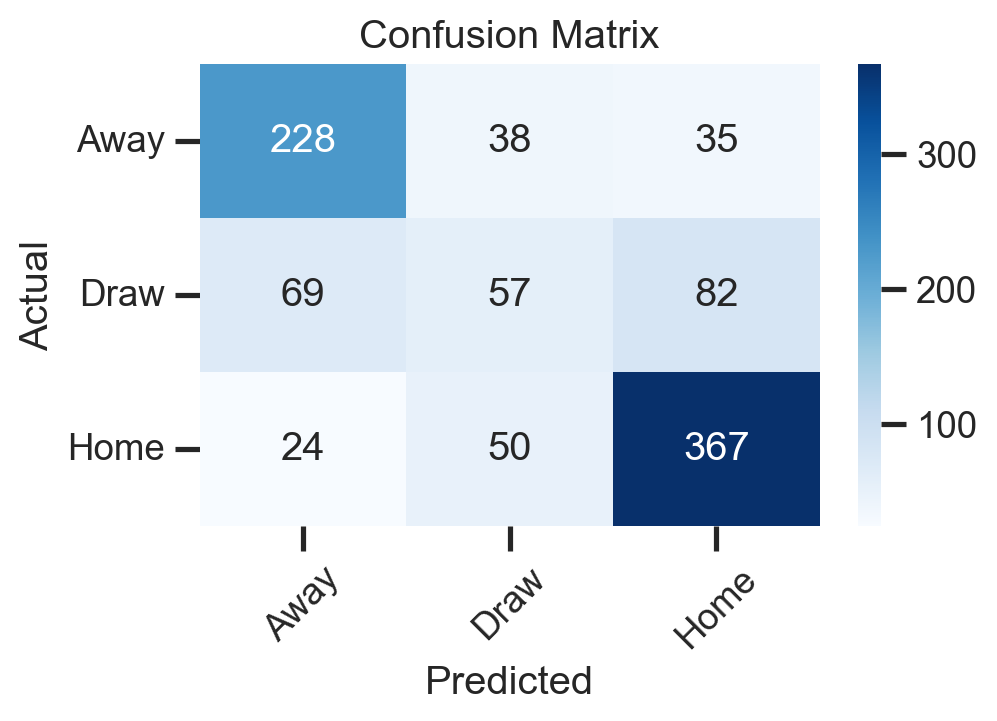

In [102]:
plot_confusion_matrix(y_test, svc_predictions)

## LOGISTIC REGRESSION MODEL

In [103]:
lgr = LogisticRegression(random_state=45)

In [104]:
param_grid_lgr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, ],
    'class_weight': [None, 'balanced'],
    'solver':['lbfgs','newton-cg','sag','saga'],
    'multi_class':['multinomial']
}

In [105]:
grid_lgr = GridSearchCV(
    lgr,
    param_grid_lgr,
    scoring='balanced_accuracy',
    return_train_score=True,
    cv=5
)

In [106]:
grid_lgr.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=45),
             param_grid={'C': [0.001, 0.01, 0.1],
                         'class_weight': [None, 'balanced'],
                         'multi_class': ['multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             return_train_score=True, scoring='balanced_accuracy')

In [107]:
grid_lgr_results = pd.DataFrame(grid_lgr.cv_results_)
grid_lgr_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_class_weight', 'param_multi_class', 'param_penalty',
       'param_solver', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [108]:
grid_lgr_results[
    ['param_C','param_penalty', 'mean_train_score', 'std_train_score',
     'mean_test_score','std_test_score', 'rank_test_score'  ] 
].sort_values('mean_test_score', ascending=False)

,param_C,param_penalty,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
47,0.1,l2,0.640148,0.004895,0.633101,0.023158,1
46,0.1,l2,0.640241,0.004744,0.633101,0.023158,1
44,0.1,l2,0.640148,0.004895,0.633101,0.023158,1
45,0.1,l2,0.640148,0.004895,0.633101,0.023158,1
43,0.1,l1,0.633406,0.008044,0.632869,0.023628,5
35,0.1,l1,0.605190,0.006666,0.599973,0.018669,6
31,0.01,l2,0.597953,0.006033,0.597486,0.021358,7
30,0.01,l2,0.597953,0.006033,0.597486,0.021358,7
29,0.01,l2,0.597953,0.006033,0.597486,0.021358,7
28,0.01,l2,0.597737,0.006316,0.597486,0.021358,7


In [109]:
lgr_model = grid_lgr.best_estimator_

In [110]:
# make predictions
lgr_predictions = lgr_model.predict(X_test_preprocessed)

In [111]:
accuracy, precision, recall, f1 = evaluation(y_test, lgr_predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

new_row = {"Model": "LogisticRegression","Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1}
models = models.append(new_row, ignore_index=True)

Accuracy: 0.6631578947368421
Precision: 0.6934208804321085
Recall: 0.6631578947368421
F1 Score: 0.6739138169834751


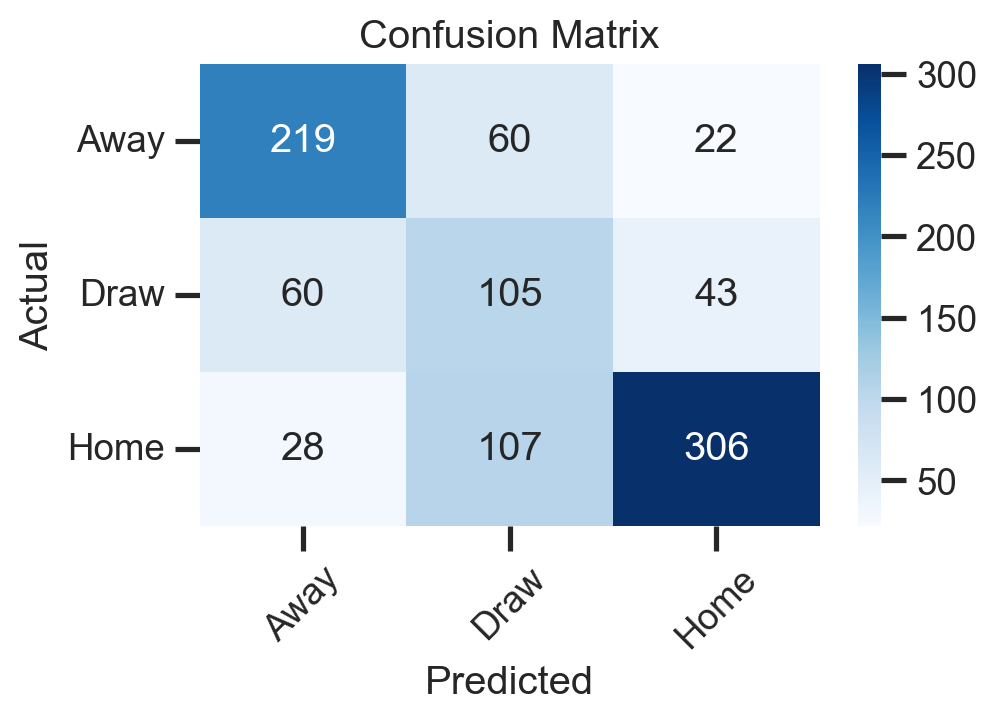

In [112]:
plot_confusion_matrix(y_test, lgr_predictions)

## RANDOMFOREST CLASSIFIER

In [113]:
rf = RandomForestClassifier(random_state=45)

In [114]:
param_grid_rfc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}


In [115]:
grid_rfc = GridSearchCV(
    rf,
    param_grid_rfc,
    scoring='balanced_accuracy',
    return_train_score=True,
    cv=5
)


In [116]:
grid_rfc.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=45),
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='balanced_accuracy')

In [117]:
grid_rfc_results = pd.DataFrame(grid_rfc.cv_results_)
grid_rfc_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_bootstrap', 'param_max_depth', 'param_max_features',
       'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [118]:
grid_rfc_results[
    ['param_max_depth','param_n_estimators','param_min_samples_leaf', 'param_min_samples_split', 'mean_train_score', 'std_train_score',
     'mean_test_score','std_test_score', 'rank_test_score'  ] 
].sort_values('mean_test_score', ascending=False)

,param_max_depth,param_n_estimators,param_min_samples_leaf,param_min_samples_split,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
385,10,100,1,10,0.908536,0.003314,0.620960,0.023219,1
484,15,100,4,10,0.955937,0.004981,0.616343,0.017407,2
361,10,100,2,2,0.952546,0.004448,0.616217,0.020492,3
334,10,100,2,2,0.952546,0.004448,0.616217,0.020492,3
350,10,200,4,10,0.892578,0.002642,0.615843,0.025494,5
...,...,...,...,...,...,...,...,...,...
78,5,50,4,10,0.621288,0.008775,0.577485,0.018637,482
319,5,100,4,5,0.626198,0.006490,0.577464,0.018455,483
316,5,100,4,2,0.626198,0.006490,0.577464,0.018455,483
322,5,100,4,10,0.626544,0.004938,0.577444,0.017932,485


In [119]:
rfc_model = grid_rfc.best_estimator_

In [120]:
# make predictions
rfc_predictions = rfc_model.predict(X_test_preprocessed)

In [121]:
accuracy, precision, recall, f1 = evaluation(y_test, rfc_predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

new_row = {"Model": "RandomForestClassifier","Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1}
models = models.append(new_row, ignore_index=True)

Accuracy: 0.68
Precision: 0.6541559707423443
Recall: 0.68
F1 Score: 0.6598209199315618


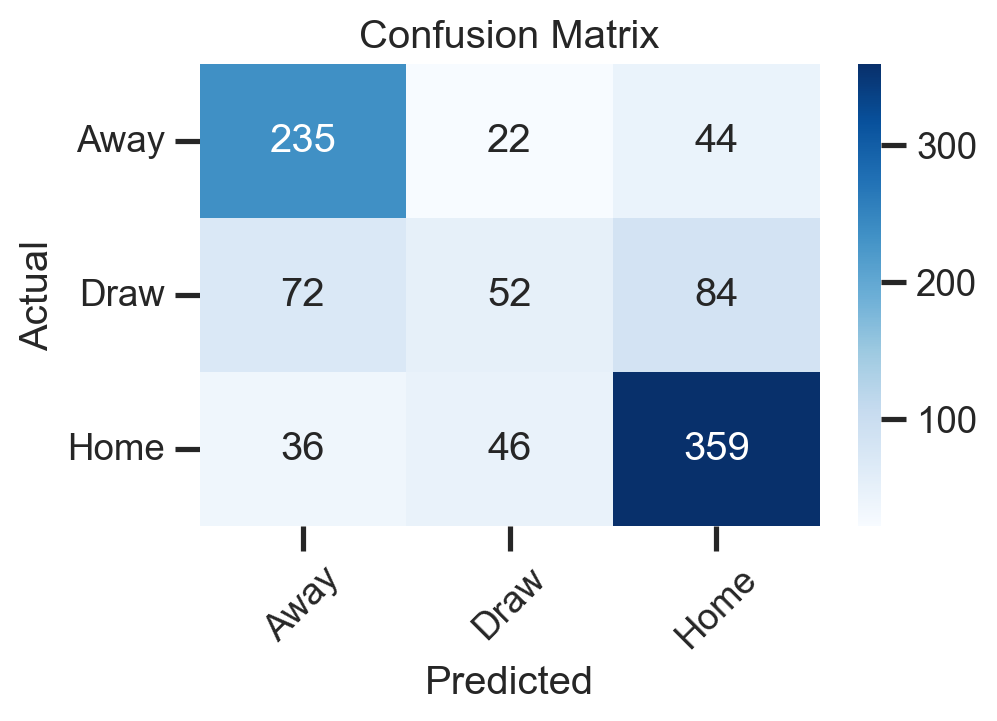

In [122]:
plot_confusion_matrix(y_test, rfc_predictions)

### MLP CLASSIFIER MODEL

In [123]:
mlp = MLPClassifier()


In [124]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}


In [125]:
grid_mlp = GridSearchCV(
    mlp,
    param_grid_mlp,
    scoring='balanced_accuracy',
    return_train_score=True,
    n_jobs=1,
    cv=5
)

In [126]:
grid_mlp.fit(X_train_preprocessed, y_train)


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 50)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['adam', 'sgd']},
             return_train_score=True, scoring='balanced_accuracy')

In [127]:
grid_mlp_results = pd.DataFrame(grid_mlp.cv_results_)
grid_mlp_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_activation', 'param_alpha', 'param_hidden_layer_sizes',
       'param_learning_rate', 'param_solver', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [128]:
grid_mlp_results[
    ['param_activation','param_alpha', 'param_learning_rate', 'mean_train_score', 'std_train_score',
     'mean_test_score','std_test_score', 'rank_test_score'  ] 
].sort_values('mean_test_score', ascending=False)


,param_activation,param_alpha,param_learning_rate,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
114,tanh,0.001,constant,0.628830,0.016523,0.623224,0.021377,1
138,tanh,0.01,constant,0.632017,0.006888,0.622771,0.025910,2
98,tanh,0.001,invscaling,0.626715,0.004982,0.622223,0.019351,3
80,tanh,0.0001,invscaling,0.628661,0.009801,0.622203,0.026475,4
74,tanh,0.0001,invscaling,0.627406,0.005186,0.621595,0.018679,5
...,...,...,...,...,...,...,...,...
195,logistic,0.01,invscaling,0.329226,0.018495,0.327079,0.036464,212
15,relu,0.0001,invscaling,0.315523,0.022164,0.319378,0.025657,213
9,relu,0.0001,invscaling,0.322294,0.065979,0.318596,0.058997,214
39,relu,0.001,invscaling,0.316686,0.021037,0.316982,0.022237,215


In [129]:
mlp_model = grid_mlp.best_estimator_

In [130]:
# make predictions
mlp_predictions = mlp_model.predict(X_test_preprocessed)

In [131]:
accuracy, precision, recall, f1 = evaluation(y_test, mlp_predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

new_row = {"Model": "MLPClassifier","Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1}
models = models.append(new_row, ignore_index=True)

Accuracy: 0.68
Precision: 0.6523994259415722
Recall: 0.68
F1 Score: 0.6614938882575377


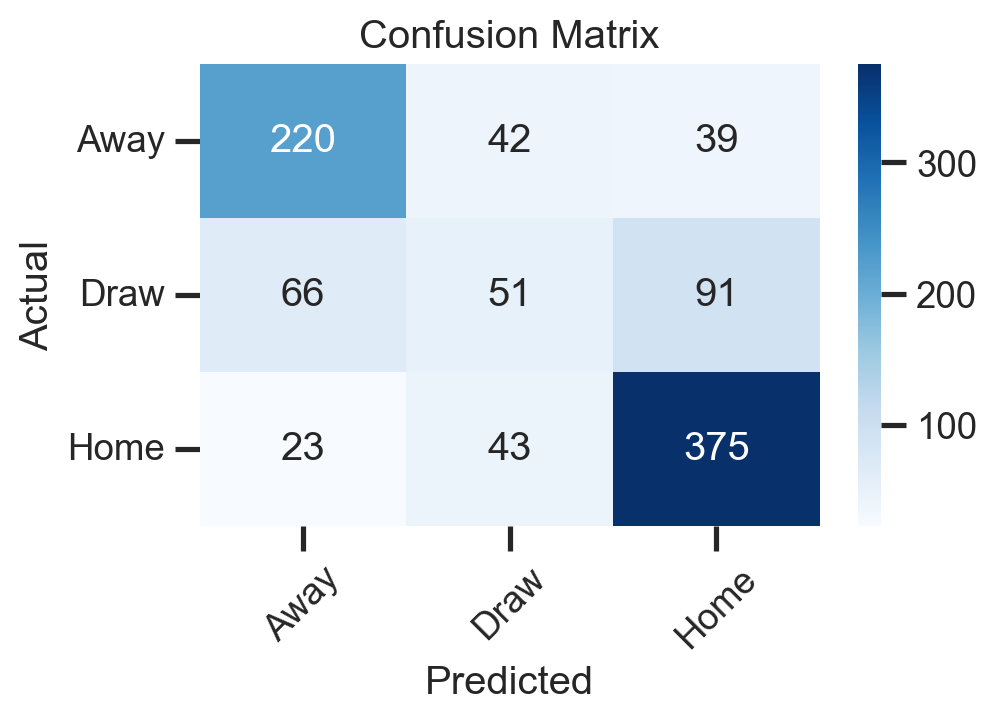

In [132]:
plot_confusion_matrix(y_test, mlp_predictions)

### ESEMBLE MODEL

In [144]:
ensembled_model = [svc_model,rfc_model,mlp_model]

In [145]:
for est in ensembled_model:
    est.fit(X_train_preprocessed, y_train)

In [146]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(
    [
        ("rfc", rfc_model), 
        #("lgr", lgr_model), 
        ("scv", svc_model),
        ("mlp", mlp_model)
    ]
)
ensemble.fit(X_train_preprocessed, y_train)

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=10,
                                                     max_features='log2',
                                                     min_samples_split=10,
                                                     random_state=45)),
                             ('scv',
                              SVC(C=1, kernel='linear', random_state=42)),
                             ('mlp',
                              MLPClassifier(activation='tanh', alpha=0.001,
                                            hidden_layer_sizes=(100, 50)))])

In [147]:
all_clf = ensembled_model + [ ensemble ]

In [148]:
all_predictions = ensemble.predict(X_test_preprocessed)

In [149]:
accuracy, precision, recall, f1 = evaluation(y_test, all_predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

new_row = {"Model": "Ensemble","Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1}
models = models.append(new_row, ignore_index=True)

Accuracy: 0.6884210526315789
Precision: 0.6573385639557757
Recall: 0.6884210526315789
F1 Score: 0.661083908731076


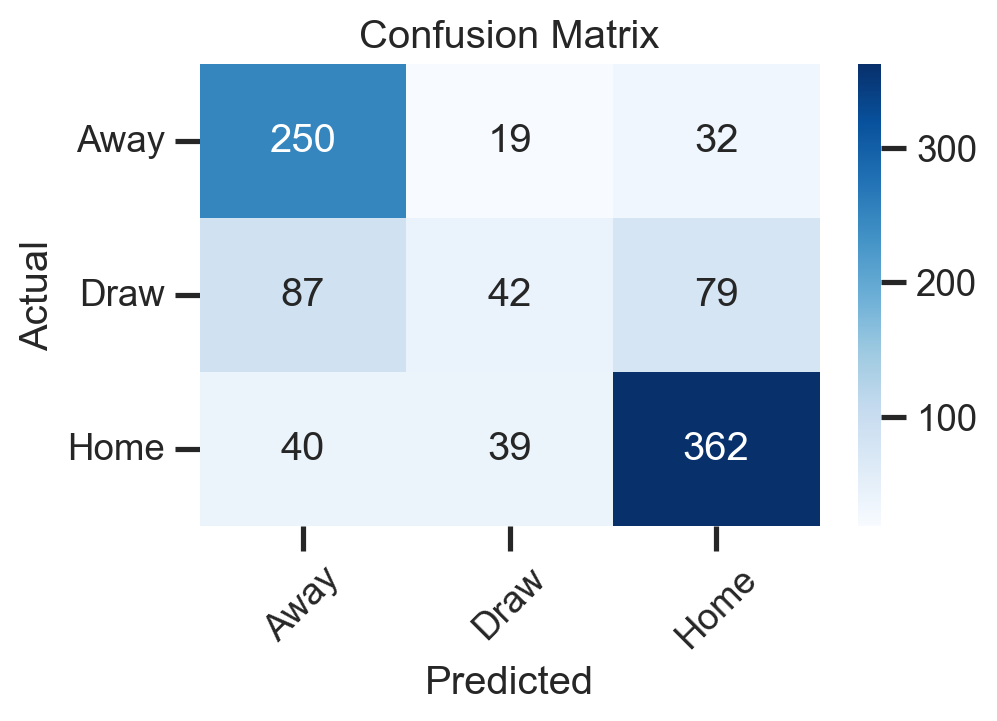

In [150]:
plot_confusion_matrix(y_test, all_predictions)

In [151]:
for est in all_clf:
    scores = cross_val_score(est, X_train_preprocessed, y_train, cv=5, scoring='balanced_accuracy')
    print(scores.mean(), scores.std())

0.6220756201092972 0.02694512234440998
0.6209603899419278 0.023219445100591294
0.6144850534884294 0.025444536862219144
0.6212889861752534 0.022800895272389793


### ALL THE MODEL LISTED ACCORDING TO ACCURACY RANK

In [152]:
models.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy,Precision,Recall,F1-score
5,Ensemble,0.688421,0.657339,0.688421,0.661084
0,Support Vector Classifier,0.686316,0.663110,0.686316,0.671348
4,Ensemble,0.682105,0.669079,0.682105,0.673944
2,RandomForestClassifier,0.680000,0.654156,0.680000,0.659821
3,MLPClassifier,0.680000,0.652399,0.680000,0.661494
1,LogisticRegression,0.663158,0.693421,0.663158,0.673914


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Support Vector Classifier'),
  Text(1, 0, 'LogisticRegression'),
  Text(2, 0, 'RandomForestClassifier'),
  Text(3, 0, 'MLPClassifier'),
  Text(4, 0, 'Ensemble')])

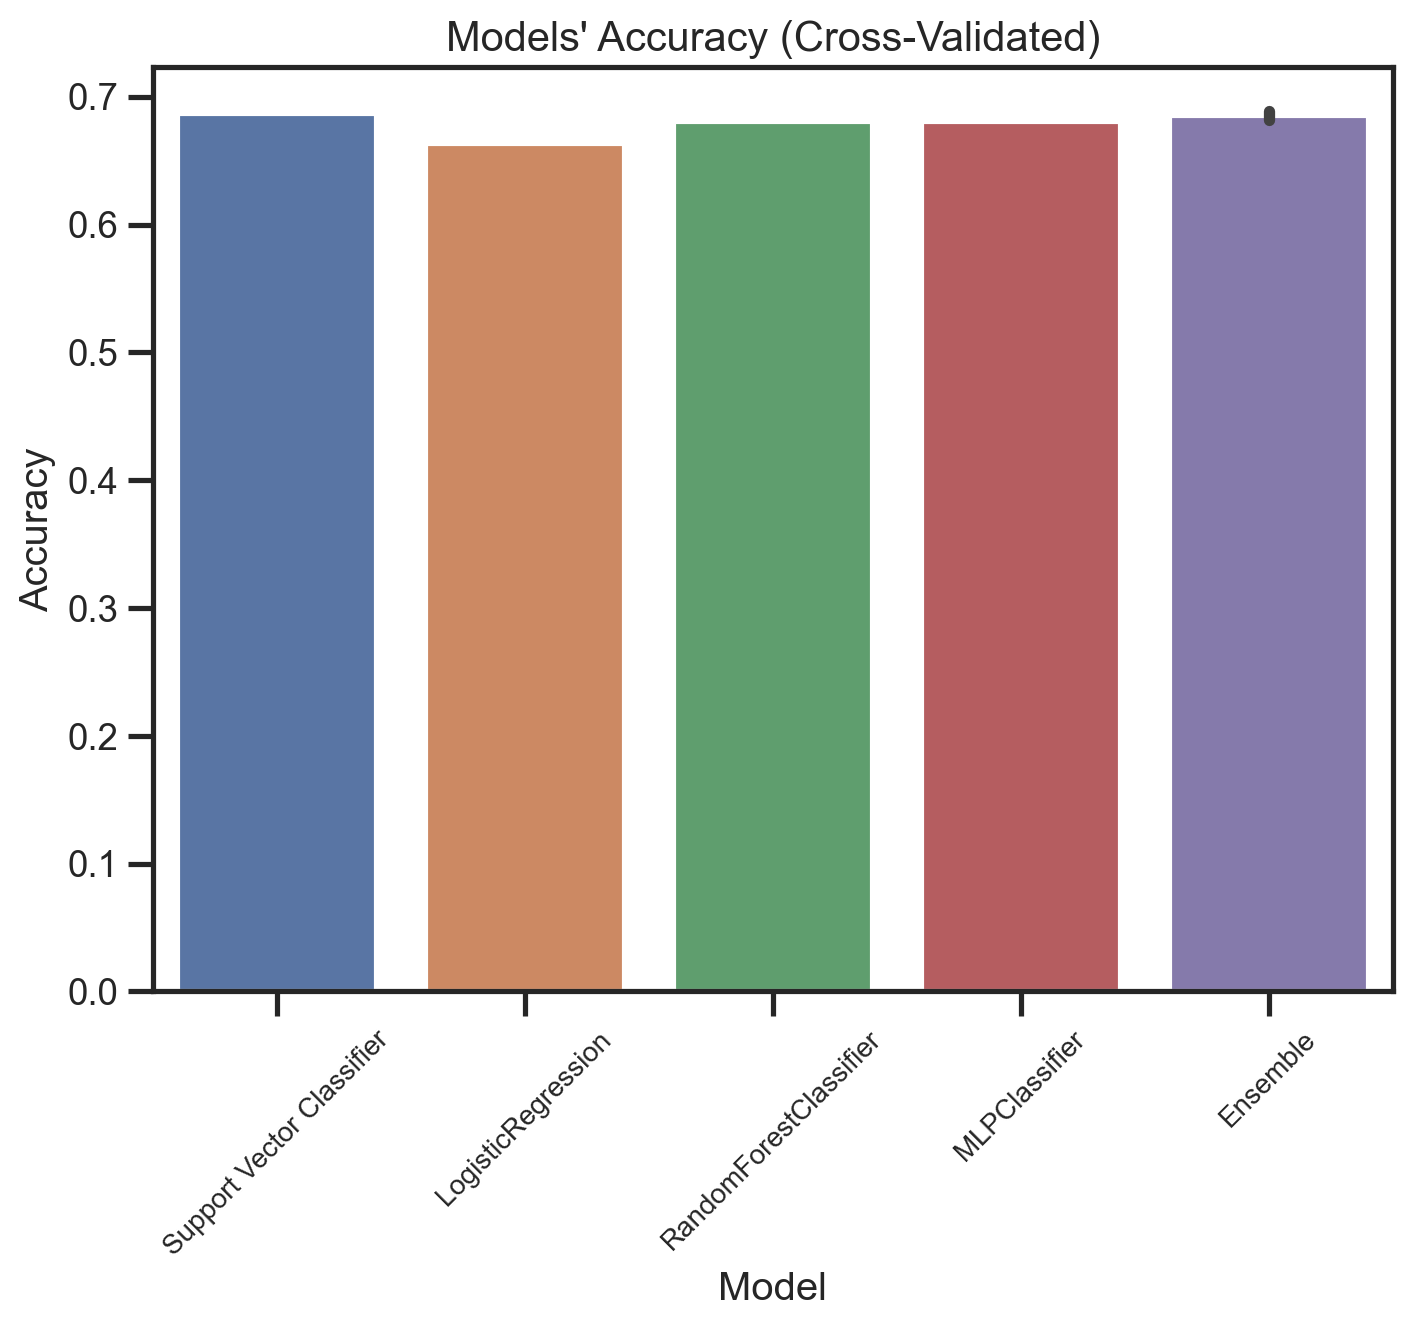

In [ ]:
sns.barplot(x=models["Model"], y=models["Accuracy"])
plt.title("Models' Accuracy (Cross-Validated)", size=15)
plt.xticks(rotation=45, size=10)

In [154]:
!pip install -q shap
import shap
shap.initjs()

In [155]:
explainer = shap.TreeExplainer(rfc_model)

In [157]:
# Calculate SHAP values for all instances in the test set
shap_values = explainer.shap_values(X_train_preprocessed)

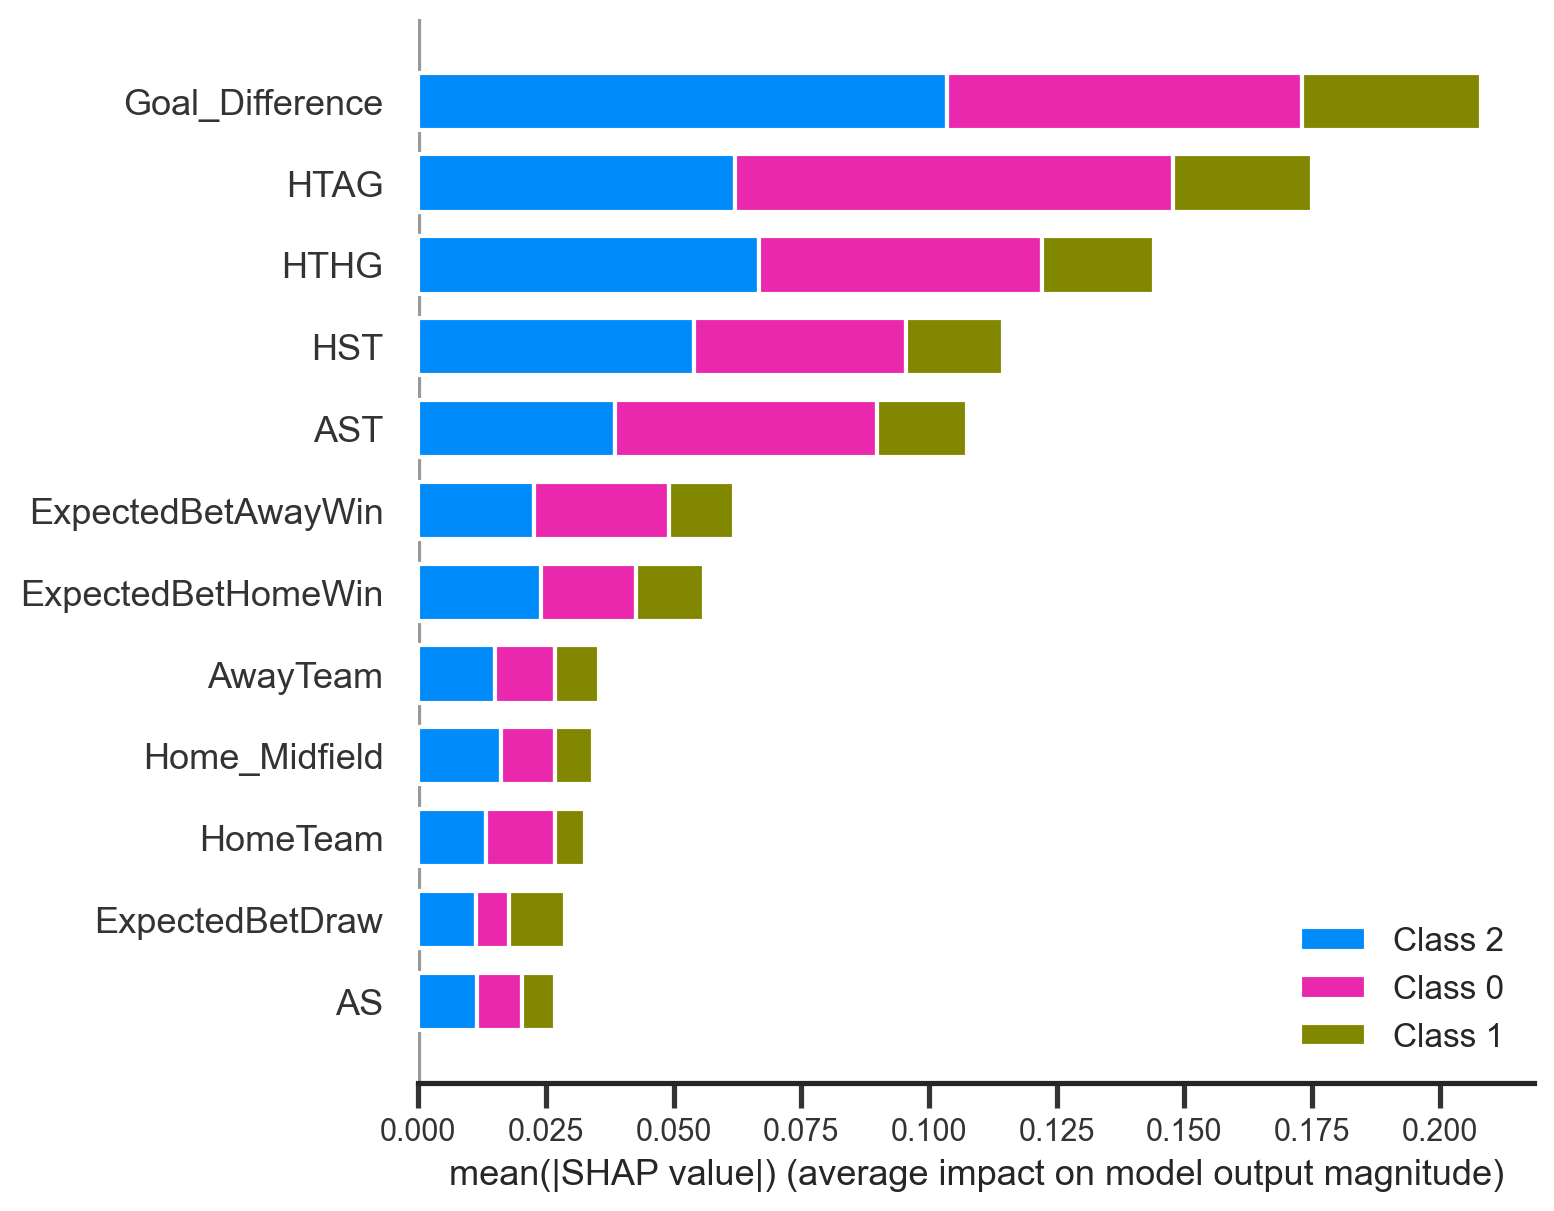

In [158]:
shap.summary_plot(
    shap_values, 
    X_train_preprocessed,
    max_display=12
)

In [174]:
actual_predicted = pd.DataFrame(dict(actual=y_test,predicted=ensemble.predict(X_test_preprocessed)))

In [177]:
actual_predicted.head(10)

,actual,predicted
484,2,2
3549,0,0
2582,1,1
3203,2,2
87,2,2
1244,1,2
316,0,0
3589,2,2
1791,1,0
3617,0,0
